#  Introduction

In traditional portfolio theory, asset relationships are typically modeled using covariance matrices and mean-variance optimization. However, these approaches can become unstable in high-dimensional settings, especially when dealing with many assets and limited data.

This notebook introduces a network-based approach to portfolio construction, leveraging the tools of graph theory to model inter-asset relationships. By transforming correlation matrices into networks, we can extract new insights and apply powerful concepts such as:

    

*   Distance correlation to capture non-linear dependencies
*   Graph visualizations to identify communities or clusters of similar assets
*   Centrality measures to detect influential or redundant assets
*   The Maximum Independent Set (MIS) to construct diversified, uncorrelated portfolios

This technique has gained traction in recent years in quantitative finance, as it offers an interpretable, robust, and alternative view of diversification and portfolio optimization.

In [7]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
import matplotlib.cm as cm
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
import matplotlib.patches as mpatches
%matplotlib inline
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = [16, 10]
np.set_printoptions(precision=5, suppress=True,formatter={'float': lambda x: f'{x:6.3f}'})
import yfinance as yf
import seaborn as sns
#imports the dcor module to calculate distance correlation
import dcor
import networkx as nx
# imports a tool to convert capital into shares
from pypfopt import discrete_allocation
import warnings
warnings.filterwarnings("ignore")

# Data Loading and Preprocessing

We begin by importing and preprocessing our financial time series dataset, which includes daily prices (Open, High, Low, Close, Volume) for a selection of stocks over a given time period.

Steps:

*   Load the dataset using pandas
*   Filter for relevant tickers and date ranges
*   Create derived features such as log returns or differences (e.g., Close_diff)
*   Handle missing values, standardize formats

This structured dataset is the foundation for building correlation matrices and financial networks.

In [9]:
tickers = ['MMM','AXP' ,'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 'GE', 'GS','HD', 'IBM' ,'INTC' ,'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE' ,'PG', 'TRV','RTX', 'UNH' ,'VZ', 'WMT', 'GOOGL', 'AMZN']

start = "2006-01-01"
df_list = list()
for stock_name in tickers:
    # daily data
    data = yf.download(stock_name,start,multi_level_index=False,auto_adjust=False,progress=False)
    data['ticker'] = stock_name
    df_list.append(data)

# combine all dataframes into a single dataframe
df = pd.concat(df_list)
df

Adj Close       Close        High         Low        Open  \
Date                                                                     
2006-01-03   37.081543   66.145485   66.346153   64.581940   65.016724   
2006-01-04   36.894058   65.811035   66.463211   65.426422   66.463211   
2006-01-05   36.556583   65.209030   65.760872   64.849495   65.560204   
2006-01-06   36.856548   65.744148   65.969902   64.916389   65.752510   
2006-01-09   37.039364   66.070236   66.747490   65.602005   65.635452   
...                ...         ...         ...         ...         ...   
2025-07-09  222.539993  222.539993  224.289993  220.470001  221.070007   
2025-07-10  222.259995  222.259995  222.789993  219.699997  221.550003   
2025-07-11  225.020004  225.020004  226.679993  222.369995  223.580002   
2025-07-14  225.690002  225.690002  226.660004  224.240005  225.070007   
2025-07-15  226.350006  226.350006  227.270004  225.460007  226.199997   

              Volume ticker  
Date                         
2006-01-03   3728171    MMM  
2006-01-04   3059368    MMM  
2006-01-05   3025282    MMM  
2006-01-06   2965482    MMM  
2006-01-09   2207338    MMM  
...              ...    ...  
2025-07-09  38155100   AMZN  
2025-07-10  30370600   AMZN  
2025-07-11  50518300   AMZN  
2025-07-14  35702600   AMZN  
2025-07-15  34851600   AMZN  

[147390 rows x 7 columns]

In [10]:
df = df.sort_index()

In [11]:
#training dataset
df_train = df.loc['2006-01-03':'2019-01-01']
df_train.tail()

Adj Close       Close        High         Low        Open  \
Date                                                                     
2018-12-31  313.372223  322.500000  323.640015  318.750000  320.500000   
2018-12-31   57.278496   67.010696   67.010696   66.230331   66.456894   
2018-12-31  124.689568  159.314377  160.242477  157.608704  159.147156   
2018-12-31   50.144806   68.190002   69.150002   67.660004   68.320000   
2018-12-31   80.617851   97.620003   98.809998   96.769997   97.589996   

              Volume ticker  
Date                         
2018-12-31   3557700     BA  
2018-12-31   7049281    RTX  
2018-12-31   2158062    MMM  
2018-12-31  15807000    XOM  
2018-12-31  13237200    JPM

In [12]:
#testing dataset
df_validate = df.loc['2019-01-01':'2022-7-28']
df_validate.tail()

Adj Close       Close        High         Low        Open  \
Date                                                                     
2022-07-28  146.382401  152.139999  152.649994  147.539993  151.759995   
2022-07-28  122.279999  122.279999  122.839996  118.080002  121.570000   
2022-07-28  146.737610  155.740005  158.889999  152.110001  158.649994   
2022-07-28  113.539070  114.220001  114.339996  111.459999  112.370003   
2022-07-28  277.507172  299.630005  301.239990  293.170013  295.000000   

              Volume ticker  
Date                         
2022-07-28   3587900    AXP  
2022-07-28  82245500   AMZN  
2022-07-28   1458700    TRV  
2022-07-28  32816600  GOOGL  
2022-07-28   3992100     HD

In [13]:
# sets each column as a stock and every row as a daily closing price
df_validate = df_validate.pivot(columns='ticker', values='Adj Close')
df_validate

ticker            AAPL        AMZN         AXP          BA         CAT  \
Date                                                                     
2019-01-02   37.617855   76.956497   87.314049  314.645142  109.192696   
2019-01-03   33.870842   75.014000   85.609718  302.100586  104.985008   
2019-01-04   35.316761   78.769501   89.467354  317.822601  110.721970   
2019-01-07   35.238144   81.475502   89.952965  318.823425  110.791107   
2019-01-08   35.909889   82.829002   90.392815  330.891937  112.121658   
...                ...         ...         ...         ...         ...   
2022-07-22  151.656891  122.419998  147.219513  158.160004  169.686478   
2022-07-25  150.534927  121.139999  147.970001  156.639999  172.716919   
2022-07-26  149.206253  114.809998  144.159836  155.919998  172.165924   
2022-07-27  154.314285  120.970001  145.891693  156.089996  175.984848   
2022-07-28  154.865463  122.279999  146.382401  159.089996  178.445328   

ticker           CSCO         CVX         DIS         GE       GOOGL  ...  \
Date                                                                  ...   
2019-01-02  35.054852   83.217972  105.889084  37.460503   52.419624  ...   
2019-01-03  33.779968   81.624130  103.323730  37.507034   50.967827  ...   
2019-01-04  35.301590   83.315712  106.511002  38.298138   53.582150  ...   
2019-01-07  35.540119   84.398308  107.434135  40.671410   53.475292  ...   
2019-01-08  35.828007   84.029915  108.269821  39.833782   53.944973  ...   
...               ...         ...         ...        ...         ...  ...   
2022-07-22  40.596371  127.807632  101.035667  41.846287  107.256744  ...   
2022-07-25  40.486805  131.610184  101.006157  41.950607  106.869072  ...   
2022-07-26  40.021130  130.581985   98.143875  43.883675  104.393906  ...   
2022-07-27  40.760738  132.301590  101.802872  43.926632  112.385979  ...   
2022-07-28  41.655571  133.303192  103.179916  44.883961  113.539070  ...   

ticker            MSFT         NKE        PFE          PG        RTX  \
Date                                                                   
2019-01-02   94.945511   68.385063  30.832544   77.515785  58.257530   
2019-01-03   91.452652   67.175415  29.969940   76.972260  55.664734   
2019-01-04   95.706047   68.929855  30.654314   78.543335  57.568985   
2019-01-07   95.828102   69.917847  30.818274   78.229126  57.542091   
2019-01-08   96.522919   70.850449  30.960861   78.517853  58.580299   
...                ...         ...        ...         ...        ...   
2022-07-22  253.919006  104.062500  43.862598  133.481049  87.761047   
2022-07-25  252.426895  104.215073  44.324940  134.386322  88.096405   
2022-07-26  245.668335  100.324165  44.778721  134.647675  84.062805   
2022-07-27  262.091736  102.860893  44.479053  135.926285  84.090759   
2022-07-28  269.571960  107.028358  43.762901  138.184875  86.065636   

ticker             TRV         UNH         VZ        WMT        XOM  
Date                                                                 
2019-01-02  101.797707  219.967072  38.818584  28.147161  51.247868  
2019-01-03   99.967674  213.968506  38.957169  28.002413  50.461014  
2019-01-04  102.933907  216.470901  39.054188  28.177315  52.321503  
2019-01-07  102.604332  216.886475  39.303642  28.509022  52.593594  
2019-01-08  102.205338  219.786392  40.453922  28.708048  52.975983  
...                ...         ...        ...        ...        ...  
2022-07-22  147.378326  496.959747  36.333050  42.328522  78.567032  
2022-07-25  150.732513  504.641785  36.586437  42.267693  81.183533  
2022-07-26  151.561691  506.662384  36.717228  39.053272  80.867737  
2022-07-27  149.771500  509.540741  36.709057  40.529209  82.618088  
2022-07-28  146.737610  516.098145  37.232182  41.540916  83.583466  

[900 rows x 30 columns]

In [14]:
#creates a new column with the difference beteween the closing and opening prices
df_train['Close_Diff'] = df_train.loc[:,'Adj Close'] - df_train.loc[:,'Open']

In [15]:
#creates a DataFrame for each time-series (see In [11])
df_train_close = df_train.pivot(columns='ticker', values='Adj Close')
df_train_open = df_train.pivot(columns='ticker', values='Open')
df_train_close_diff = df_train.pivot(columns='ticker', values='Close_Diff')
df_train_high = df_train.pivot(columns='ticker', values='High')
df_train_low = df_train.pivot(columns='ticker', values='Low')

#makes a copy of the traning dataset
df_train_close_copy = df_train_close.copy()

df_train_close.head()

ticker          AAPL    AMZN        AXP         BA        CAT       CSCO  \
Date                                                                       
2006-01-03  2.246550  2.3790  39.040638  50.119694  35.203159  11.420011   
2006-01-04  2.253163  2.3625  38.661098  50.639099  36.098473  11.681786   
2006-01-05  2.235430  2.3825  39.070404  50.041412  36.098473  12.009011   
2006-01-06  2.293136  2.3935  39.204353  49.344131  36.817142  12.283873   
2006-01-09  2.285621  2.3540  40.179253  48.931438  37.487095  12.473660   

ticker            CVX        DIS          GE      GOOGL  ...       MSFT  \
Date                                                     ...              
2006-01-03  28.028069  19.693222  104.634811  10.826711  ...  18.780910   
2006-01-04  27.947407  19.362307  104.486862  11.075718  ...  18.871872   
2006-01-05  27.605833  19.701284  104.220634  11.224972  ...  18.885878   
2006-01-06  28.108707  19.967630  104.930634  11.583682  ...  18.829895   
2006-01-09  27.966377  20.177475  104.664352  11.614528  ...  18.794905   

ticker           NKE        PFE         PG        RTX        TRV        UNH  \
Date                                                                          
2006-01-03  8.359502   9.974004  34.022324  22.662172  28.941040  48.620510   
2006-01-04  8.320601  10.296964  34.085995  22.525873  29.261957  48.738659   
2006-01-05  8.371173  10.309546  33.976017  22.441687  29.545143  48.589024   
2006-01-06  8.344913  10.422792  33.941284  22.513842  29.708767  49.542034   
2006-01-09  8.461625  10.422792  34.195980  22.770418  29.721367  48.360596   

ticker             VZ        WMT        XOM  
Date                                         
2006-01-03  10.040698  10.321806  30.159996  
2006-01-04  10.334846  10.341900  30.211573  
2006-01-05  10.453831  10.201241  30.061985  
2006-01-06  10.495674  10.243666  30.655184  
2006-01-09  10.539202  10.205707  30.639721  

[5 rows x 30 columns]

In [16]:
stocks = df_train_close.columns.tolist()

#list of training DataFrames containing each time-series
df_train_list = [df_train_close, df_train_open, df_train_close_diff, df_train_high, df_train_low]

#detrends each time-series for each DataFrame
for df in df_train_list:
    for s in stocks:
        df[s] = df[s].diff()

In [17]:
df_train_close.head()

ticker          AAPL    AMZN       AXP        BA       CAT      CSCO  \
Date                                                                   
2006-01-03       NaN     NaN       NaN       NaN       NaN       NaN   
2006-01-04  0.006612 -0.0165 -0.379539  0.519405  0.895313  0.261775   
2006-01-05 -0.017732  0.0200  0.409306 -0.597687  0.000000  0.327226   
2006-01-06  0.057705  0.0110  0.133949 -0.697281  0.718670  0.274861   
2006-01-09 -0.007515 -0.0395  0.974899 -0.412693  0.669952  0.189787   

ticker           CVX       DIS        GE     GOOGL  ...      MSFT       NKE  \
Date                                                ...                       
2006-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2006-01-04 -0.080662 -0.330915 -0.147949  0.249007  ...  0.090961 -0.038901   
2006-01-05 -0.341574  0.338978 -0.266228  0.149254  ...  0.014006  0.050572   
2006-01-06  0.502874  0.266346  0.709999  0.358710  ... -0.055983 -0.026260   
2006-01-09 -0.142330  0.209845 -0.266281  0.030846  ... -0.034990  0.116713   

ticker           PFE        PG       RTX       TRV       UNH        VZ  \
Date                                                                     
2006-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2006-01-04  0.322960  0.063671 -0.136299  0.320917  0.118149  0.294147   
2006-01-05  0.012583 -0.109978 -0.084187  0.283186 -0.149635  0.118985   
2006-01-06  0.113246 -0.034733  0.072155  0.163624  0.953011  0.041843   
2006-01-09  0.000000  0.254696  0.256577  0.012600 -1.181438  0.043528   

ticker           WMT       XOM  
Date                            
2006-01-03       NaN       NaN  
2006-01-04  0.020094  0.051577  
2006-01-05 -0.140658 -0.149588  
2006-01-06  0.042424  0.593199  
2006-01-09 -0.037959 -0.015463  

[5 rows x 30 columns]

In [18]:
#counts the missing values in each column
df_train_close.isnull().sum()

ticker
AAPL     1
AMZN     1
AXP      1
BA       1
CAT      1
CSCO     1
CVX      1
DIS      1
GE       1
GOOGL    1
GS       1
HD       1
IBM      1
INTC     1
JNJ      1
JPM      1
KO       1
MCD      1
MMM      1
MRK      1
MSFT     1
NKE      1
PFE      1
PG       1
RTX      1
TRV      1
UNH      1
VZ       1
WMT      1
XOM      1
dtype: int64

In [19]:
#drops all missing values in each DataFrame
for df in df_train_list:
    df.dropna(inplace=True)

# Correlation Matrices: Linear and Non-Linear Dependencies

🔹 **Pearson Correlation**

The Pearson correlation coefficient is a measure of linear dependence between two variables. While widely used, it is sensitive to outliers and cannot capture non-linear relationships.

🔹 **Distance Correlation**

We then introduce Distance Correlation, which generalizes Pearson by capturing any kind of statistical dependence, linear or not. This is particularly useful in finance where asset returns can have hidden, non-linear linkages (e.g., due to common macroeconomic exposures or volatility clustering).

  
  📚 Historical note: Distance correlation was introduced in 2007 by Székely et al. and has since been applied in machine learning, bioinformatics, and finance for dependency detection.

# Calculating the Distance Correlation Matrix

In [20]:
#function to compute the distance correlation (dcor) matrix from a DataFrame and output a DataFrame
#of dcor values.
def df_distance_correlation(df_train):

    #initializes an empty DataFrame
    df_train_dcor = pd.DataFrame(index=stocks, columns=stocks)

    #initialzes a counter at zero
    k=0

    #iterates over the time series of each stock
    for i in stocks:

        #stores the ith time series as a vector
        v_i = df_train.loc[:, i].values

        #iterates over the time series of each stock subect to the counter k
        for j in stocks[k:]:

            #stores the jth time series as a vector
            v_j = df_train.loc[:, j].values

            #computes the dcor coefficient between the ith and jth vectors
            dcor_val = dcor.distance_correlation(v_i, v_j)

            #appends the dcor value at every ij entry of the empty DataFrame
            df_train_dcor.at[i,j] = dcor_val

            #appends the dcor value at every ji entry of the empty DataFrame
            df_train_dcor.at[j,i] = dcor_val

        #increments counter by 1
        k+=1

    #returns a DataFrame of dcor values for every pair of stocks
    return df_train_dcor

In [21]:
df_train_dcor_list = [df_distance_correlation(df) for df in df_train_list]

In [22]:
df_train_dcor_list[0]

AAPL      AMZN       AXP        BA       CAT      CSCO       CVX  \
AAPL        1.0  0.458551   0.33124  0.359986      0.37  0.401464  0.291099   
AMZN   0.458551       1.0  0.332545  0.400348  0.331138  0.382674  0.270203   
AXP     0.33124  0.332545       1.0  0.438911  0.486303  0.495935  0.423766   
BA     0.359986  0.400348  0.438911       1.0  0.488449  0.428169  0.387838   
CAT        0.37  0.331138  0.486303  0.488449       1.0  0.464611  0.515469   
CSCO   0.401464  0.382674  0.495935  0.428169  0.464611       1.0  0.422101   
CVX    0.291099  0.270203  0.423766  0.387838  0.515469  0.422101       1.0   
DIS    0.350732   0.35544  0.472857  0.430101  0.413839  0.453928  0.397422   
GE     0.291465  0.256016  0.511478   0.39881  0.469383  0.448236  0.461292   
GOOGL  0.470616  0.583166  0.415605  0.399957  0.385767  0.454668  0.328031   
GS     0.318326  0.298139  0.602881  0.406429   0.46103   0.47374  0.414171   
HD     0.338636  0.378656  0.449129  0.410042  0.391057  0.407388  0.328712   
IBM    0.361591  0.322814  0.480876   0.40131  0.457445  0.518492  0.458284   
INTC   0.403751  0.367808  0.449314  0.408753  0.457542  0.554189  0.391275   
JNJ    0.265518  0.296753  0.400495  0.387226  0.342462  0.394532  0.373235   
JPM    0.334592   0.31101  0.642931  0.435755  0.481411  0.486063  0.452153   
KO     0.236365  0.233265  0.371129  0.319264  0.323588  0.355432  0.381764   
MCD    0.300072  0.318327  0.367868  0.353983  0.334274  0.362341  0.332706   
MMM    0.379085  0.370593  0.510792  0.517966  0.555972  0.513736  0.468568   
MRK    0.242659   0.25215  0.384824  0.328585  0.315362   0.37888  0.365793   
MSFT   0.458281  0.521135  0.444802   0.42232  0.425161  0.538552  0.390819   
NKE    0.335272  0.390697  0.407927  0.398163  0.363854   0.38872  0.306254   
PFE    0.281713  0.280761  0.426593  0.355179  0.344355   0.40393  0.382867   
PG     0.230947  0.214865  0.379287  0.324736  0.322301  0.364261  0.375304   
RTX    0.358565  0.339679  0.528863  0.567775  0.576338  0.499514  0.462667   
TRV    0.288385  0.276797  0.497606  0.403314  0.402211    0.4199  0.415899   
UNH    0.330588  0.352786   0.36174  0.391422  0.314703  0.331494  0.301978   
VZ     0.224325  0.215324  0.385581  0.299148   0.31838  0.355358   0.36411   
WMT    0.232316  0.232332  0.345265  0.291503  0.292738  0.342686  0.278893   
XOM    0.279543  0.249741  0.428688   0.38125  0.507818  0.432268  0.774279   

            DIS        GE     GOOGL  ...      MSFT       NKE       PFE  \
AAPL   0.350732  0.291465  0.470616  ...  0.458281  0.335272  0.281713   
AMZN    0.35544  0.256016  0.583166  ...  0.521135  0.390697  0.280761   
AXP    0.472857  0.511478  0.415605  ...  0.444802  0.407927  0.426593   
BA     0.430101   0.39881  0.399957  ...   0.42232  0.398163  0.355179   
CAT    0.413839  0.469383  0.385767  ...  0.425161  0.363854  0.344355   
CSCO   0.453928  0.448236  0.454668  ...  0.538552   0.38872   0.40393   
CVX    0.397422  0.461292  0.328031  ...  0.390819  0.306254  0.382867   
DIS         1.0  0.451253  0.405541  ...  0.411865  0.450593  0.411395   
GE     0.451253       1.0  0.347458  ...  0.373554  0.363752  0.418955   
GOOGL  0.405541  0.347458       1.0  ...  0.550879  0.399618  0.346541   
GS     0.437899  0.485995   0.40726  ...  0.395092  0.346824  0.381246   
HD     0.433295  0.378945   0.39046  ...  0.410907  0.477591  0.364501   
IBM    0.457513  0.484934  0.417348  ...  0.474332  0.384826  0.402961   
INTC   0.414791  0.413501  0.428938  ...  0.536187   0.35845  0.377381   
JNJ    0.392534   0.38396  0.362718  ...  0.388707  0.358762  0.536705   
JPM    0.468367  0.529058    0.4074  ...  0.434439  0.380895  0.431219   
KO      0.37132  0.368357  0.305113  ...  0.361123  0.331516  0.387857   
MCD    0.359912  0.343214  0.354466  ...  0.392535  0.365183  0.347283   
MMM    0.491162   0.52999  0.445315  ...  0.487774  0.436121  0.461945   
MRK    0.381107  0.379827  0.315405  ...   0.35228  0.317928  0.564148   
MSFT   

# Building a Time-Series Correlation Network

In [23]:
# takes in a pre-processed dataframe and returns a time-series correlation
# network with pairwise distance correlation values as the edges
def build_corr_nx(df_train):

    # converts the distance correlation dataframe to a numpy matrix with dtype float
    cor_matrix = df_train.values.astype('float')

    # Since dcor ranges between 0 and 1, (0 corresponding to independence and 1
    # corresponding to dependence), 1 - cor_matrix results in values closer to 0
    # indicating a higher degree of dependence where values close to 1 indicate a lower degree of
    # dependence. This will result in a network with nodes in close proximity reflecting the similarity
    # of their respective time-series and vice versa.
    sim_matrix = 1 - cor_matrix

    # transforms the similarity matrix into a graph
    G = nx.from_numpy_array(sim_matrix)

    # extracts the indices (i.e., the stock names from the dataframe)
    stock_names = df_train.index.values

    # relabels the nodes of the network with the stock names
    G = nx.relabel_nodes(G, lambda x: stock_names[x])

    # assigns the edges of the network weights (i.e., the dcor values)
    G.edges(data=True)

    # copies G
    ## we need this to delete edges or othwerwise modify G
    H = G.copy()

    # iterates over the edges of H (the u-v pairs) and the weights (wt)
    for (u, v, wt) in G.edges.data('weight'):
        # selects edges with dcor values less than or equal to 0.33
        if wt >= 1 - 0.325:
            # removes the edges
            H.remove_edge(u, v)

        # selects self-edges
        if u == v:
            # removes the self-edges
            H.remove_edge(u, v)

    # returns the final stock correlation network
    return H

In [24]:
#builds the distance correlation networks for the Open, Close, High, Low, and Close_diff time series
H_close = build_corr_nx(df_train_dcor_list[0])
H_open = build_corr_nx(df_train_dcor_list[1])
H_close_diff = build_corr_nx(df_train_dcor_list[2])
H_high = build_corr_nx(df_train_dcor_list[3])
H_low = build_corr_nx(df_train_dcor_list[4])

# Plotting a Time-Series Correlation Network

In [27]:
# function to display the network from the distance correlation matrix
def plt_corr_nx(H, title):

    # creates a set of tuples: the edges of G and their corresponding weights
    edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())

    # This draws the network with the Kamada-Kawai path-length cost-function.
    # Nodes are positioned by treating the network as a physical ball-and-spring system. The locations
    # of the nodes are such that the total energy of the system is minimized.
    pos = nx.kamada_kawai_layout(H)

    with sns.axes_style('whitegrid'):
        # figure size and style
        plt.figure(figsize=(12, 9))
        plt.title(title, size=16)

        # computes the degree (number of connections) of each node
        deg = H.degree

        # list of node names
        nodelist = []
        # list of node sizes
        node_sizes = []

        # iterates over deg and appends the node names and degrees
        for n, d in deg:
            nodelist.append(n)
            node_sizes.append(d)

        # draw nodes
        nx.draw_networkx_nodes(
            H,
            pos,
            node_color="#DA70D6",
            nodelist=nodelist,
            node_size=np.power(node_sizes, 2.33),
            alpha=0.8,
        )

        # node label styles
        nx.draw_networkx_labels(H, pos, font_size=13, font_family="sans-serif")

        # color map
        cmap = sns.cubehelix_palette(3, as_cmap=True, reverse=True)

        # draw edges
        nx.draw_networkx_edges(
            H,
            pos,
            style="solid",
            edge_color=weights,
            edge_cmap=cmap,
            edge_vmin=min(weights),
            edge_vmax=max(weights),
        )

        # displays network without axes
        plt.axis("off")

# Visualizing Portfolio Correlations Using Physics-Inspired Graph Layouts

To intuitively understand how assets in a portfolio are correlated with one another, we use the Kamada-Kawai layout algorithm — a method grounded in physics-based graph drawing.

In this visualization approach, each asset (node) is modeled as a mass, and each connection (edge) between assets behaves like a spring. The goal is to position the nodes in such a way that the total energy of the system is minimized, much like in a mechanical system seeking equilibrium.

Edge lengths are determined by the formula:
*edge length ∝ 1−correlation*

where the correlation is derived from the distance correlation matrix. This means:

*   Nodes that are strongly correlated (high distance correlation) are drawn closer together
*   Nodes that are weakly or not correlated are placed further apart

The resulting layout has an intuitive interpretation:

*   High-degree nodes (i.e., assets highly correlated with many others) are pulled toward the center
*   Low-degree or isolated nodes are pushed toward the periphery

This reflects how well-connected an asset is within the correlation structure of the portfolio.

>  For more on physics-inspired graph drawing, see the "Force-directed graph drawing" page on Wikipedia, which provides an overview of various algorithms including Kamada-Kawai and Fruchterman-Reingold.



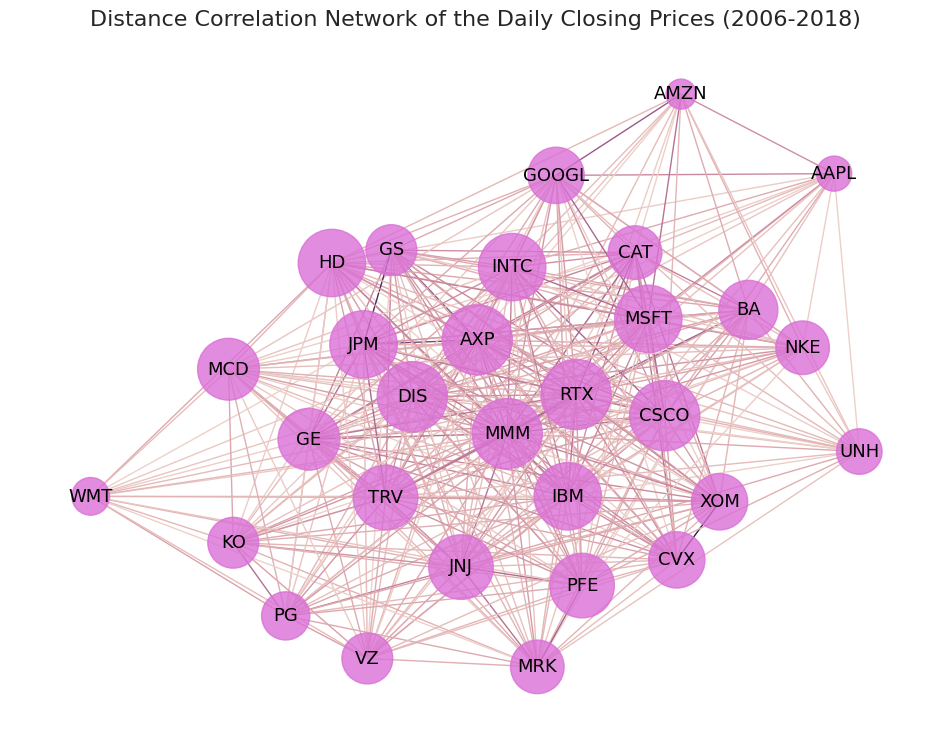

In [28]:
# plots the distance correlation network of the daily opening prices
plt_corr_nx(H_close, title='Distance Correlation Network of the Daily Closing Prices (2006-2018)')

**Interpretation :** In the visualization above, the size of each vertex reflects how many connections it has. The colorbar on the right represents the degree of dissimilarity (or distance) between stocks—the lighter the color, the greater the difference between them. Notably, several stocks stand out: Apple, Amazon, and UnitedHealth are located on the network’s outskirts, having the fewest correlations exceeding the threshold ρc = 0.325. Conversely, MMM, American Express, United Technologies, and IBM occupy the network’s core, boasting the highest number of connections above this threshold. This pattern in the closing price network suggests that our asset allocation algorithm should favor nodes on the periphery while penalizing those near the center. In the following code block, we develop a function to visualize the distribution of edges within the distance correlation network.

In [29]:
# function to visualize the degree distribution
def hist_plot(network, title, bins, xticks):

    # extracts the degrees of each vertex and stores them as a list
    deg_list = list(dict(network.degree).values())

    # sets local style
    with plt.style.context('fivethirtyeight'):
        # initializes a figure
        plt.figure(figsize=(9,6))

        # plots a pretty degree histogram with a kernel density estimator
        sns.distplot(
            deg_list,
            kde=True,
            bins = bins,
            color='darksalmon',
            hist_kws={'alpha': 0.7}

        );

        # turns the grid off
        plt.grid(False)

        # controls the number and spacing of xticks and yticks
        plt.xticks(xticks, size=11)
        plt.yticks(size=11)

        # removes the figure spines
        sns.despine(left=True, right=True, bottom=True, top=True)

        # labels the y and x axis
        plt.ylabel("Probability", size=15)
        plt.xlabel("Number of Connections", size=15)

        # sets the title
        plt.title(title, size=20);

        # draws a vertical line where the mean is
        plt.axvline(sum(deg_list)/len(deg_list),
                    color='darkorchid',
                    linewidth=3,
                    linestyle='--',
                    label='Mean = {:2.0f}'.format(sum(deg_list)/len(deg_list))
        )

        # turns the legend on
        plt.legend(loc=0, fontsize=12)

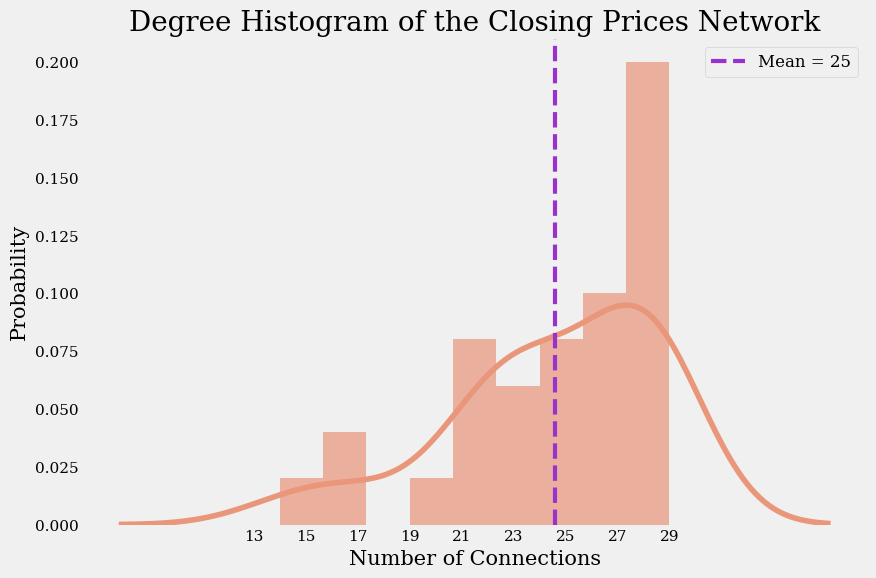

In [30]:
# plots the degree histogram of the closing prices network
hist_plot(
    H_close,
    'Degree Histogram of the Closing Prices Network',
    bins=9,
    xticks=range(13, 30, 2)
)

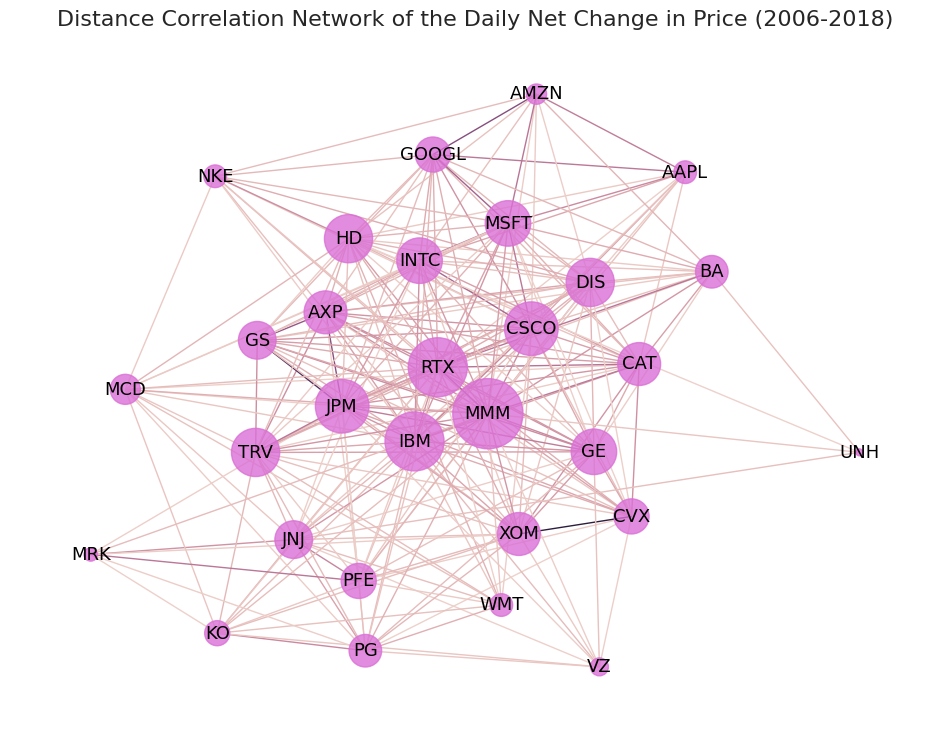

In [31]:
plt_corr_nx(
    H_close_diff,
    title='Distance Correlation Network of the Daily Net Change in Price (2006-2018)'
)

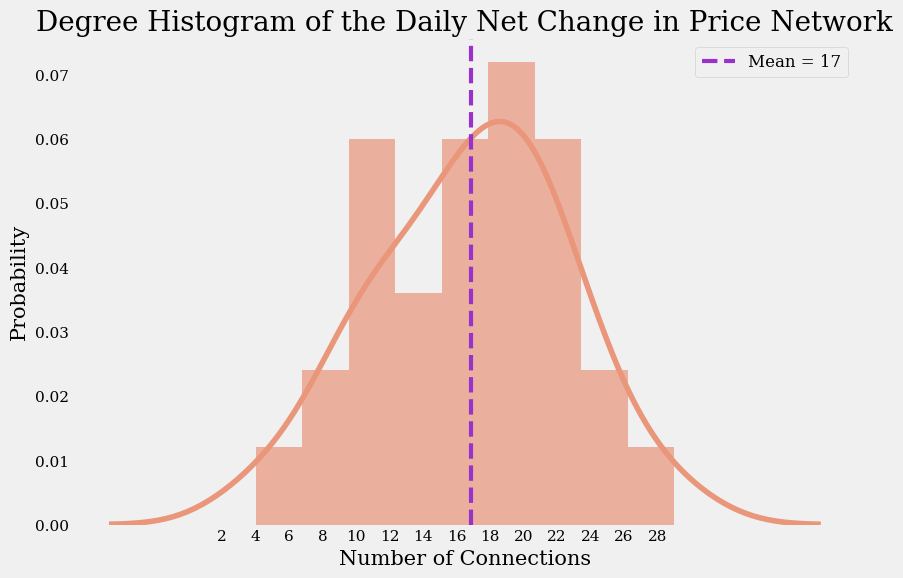

In [32]:
hist_plot(
    H_close_diff,
    'Degree Histogram of the Daily Net Change in Price Network',
    bins=9,
    xticks=range(2, 30, 2)
)

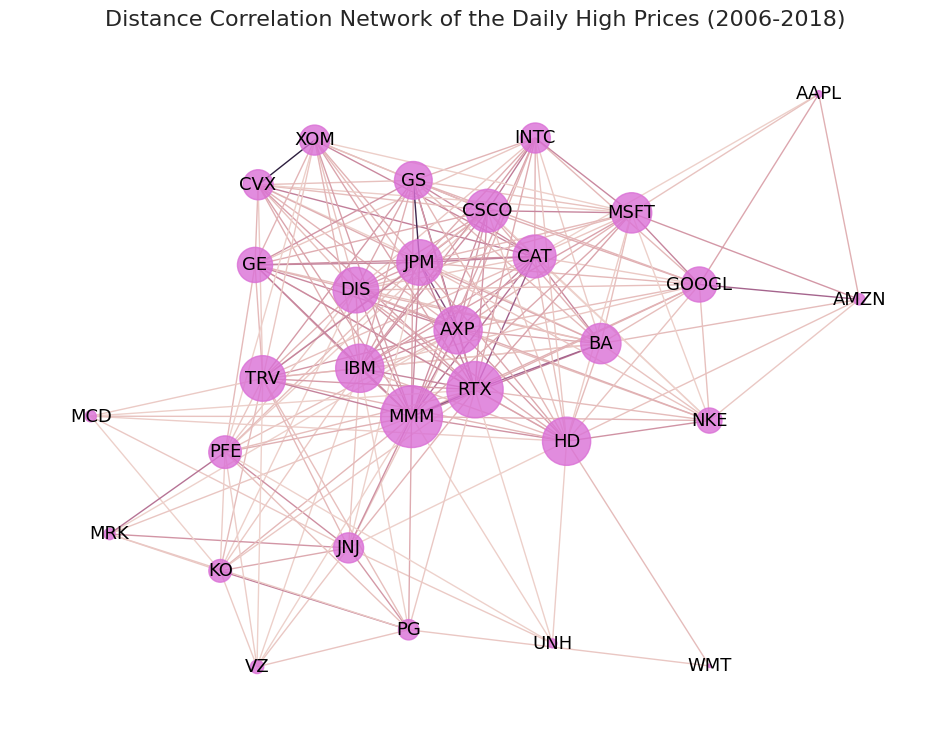

In [33]:
plt_corr_nx(
    H_high,
    title='Distance Correlation Network of the Daily High Prices (2006-2018)'
)

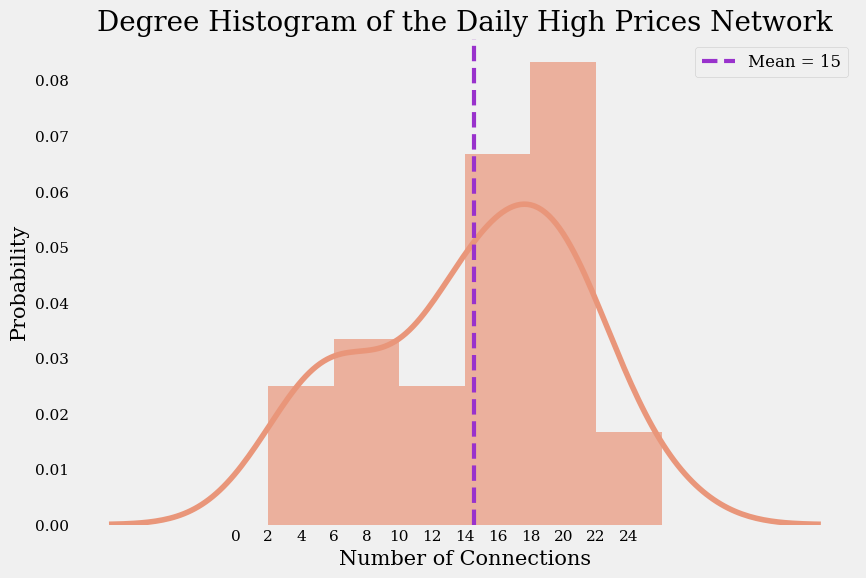

In [34]:
hist_plot(
    H_high,
    'Degree Histogram of the Daily High Prices Network',
    bins=6,
    xticks=range(0,25,2)
)

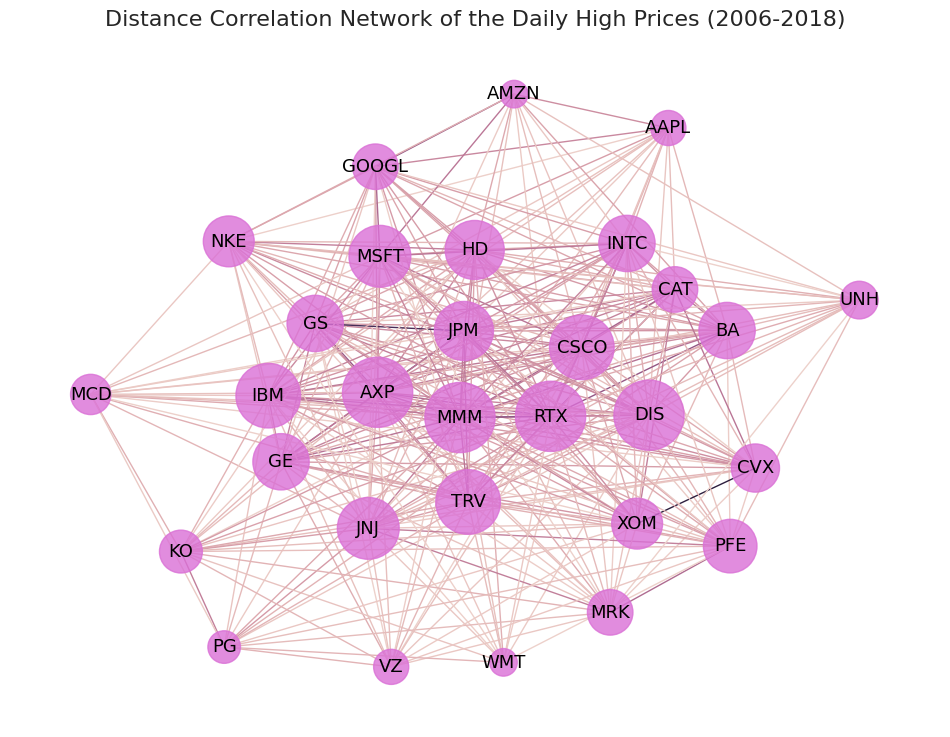

In [35]:
plt_corr_nx(
    H_low,
    title='Distance Correlation Network of the Daily High Prices (2006-2018)'
)

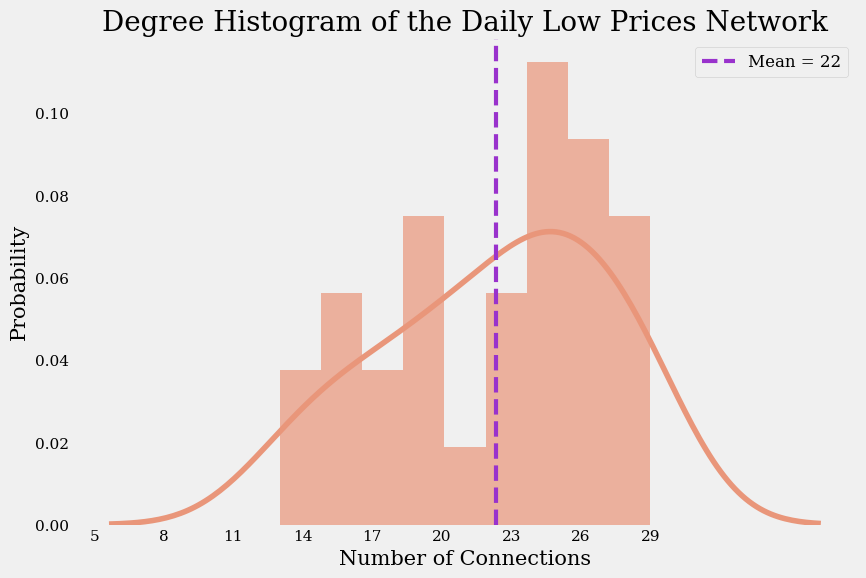

In [36]:
hist_plot(
    H_low,
    'Degree Histogram of the Daily Low Prices Network',
    bins=9,
    xticks=range(5, 30, 3)
)

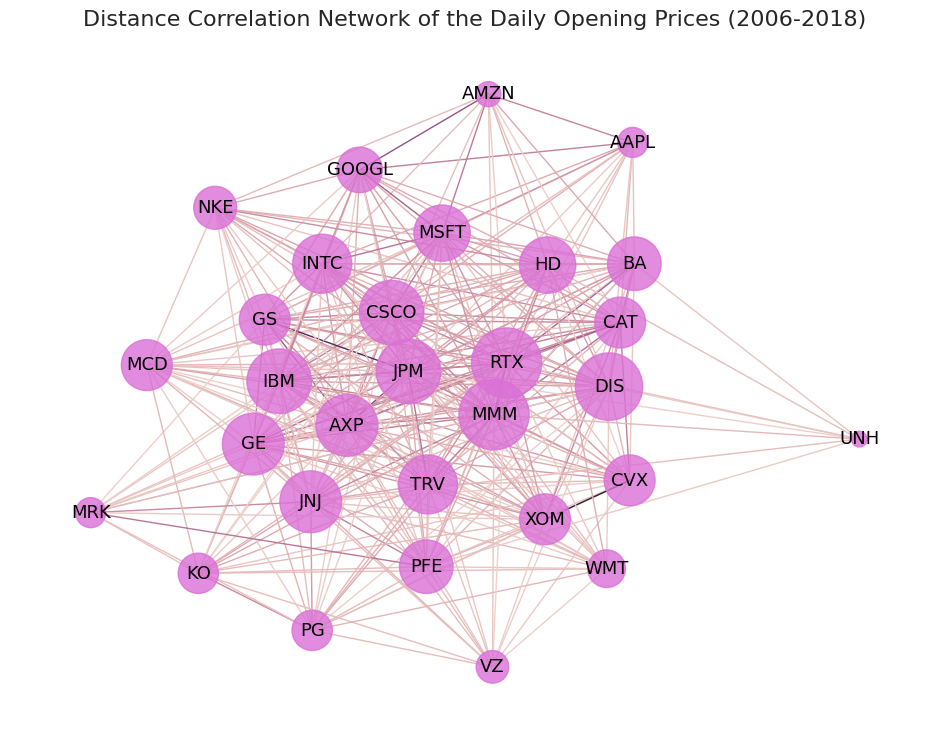

In [37]:
plt_corr_nx(
    H_open,
    title='Distance Correlation Network of the Daily Opening Prices (2006-2018)'
)

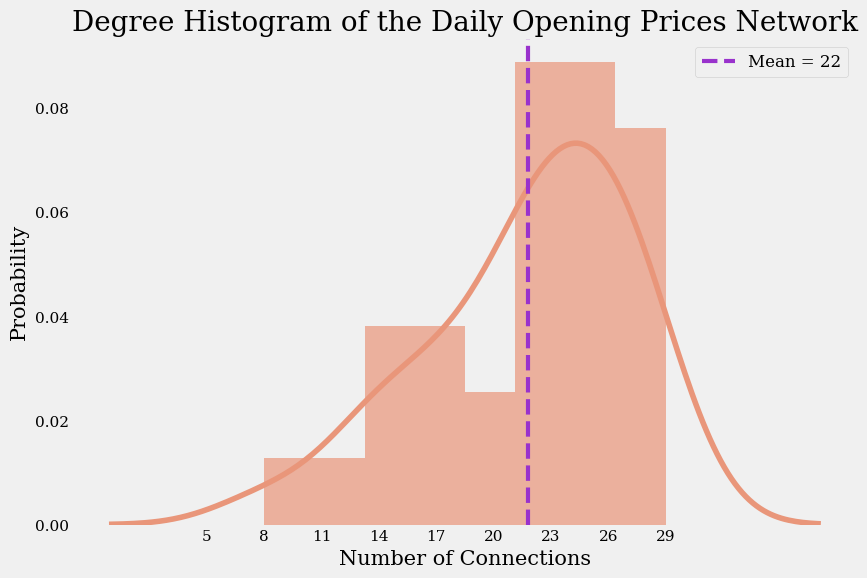

In [38]:
hist_plot(
    H_open,
    'Degree Histogram of the Daily Opening Prices Network',
    bins=8,
    xticks= range(5, 30, 3)
)

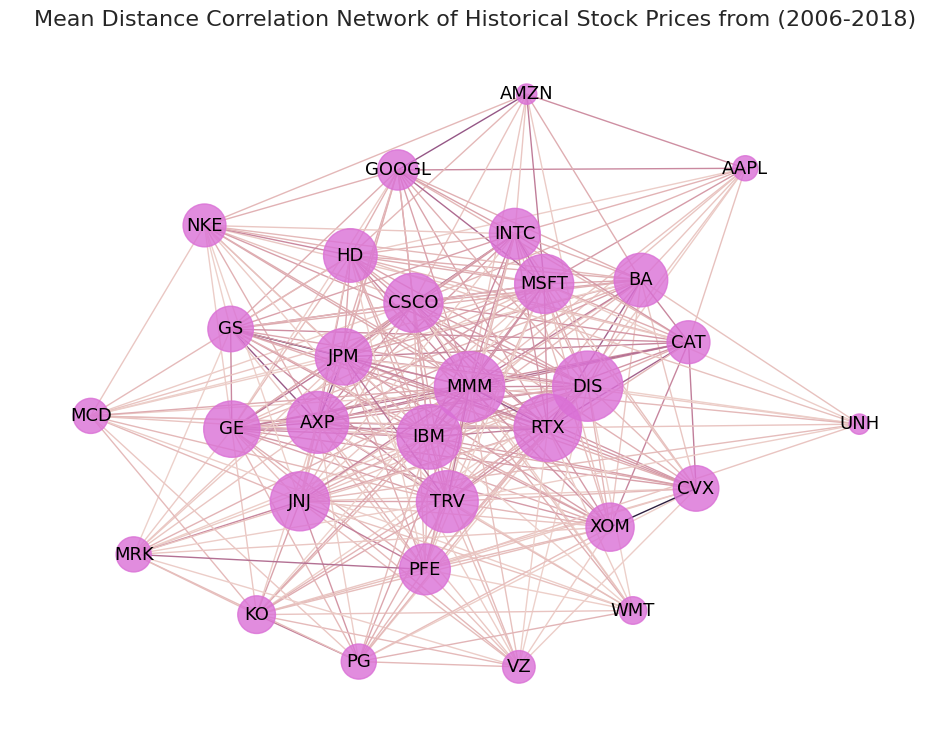

In [39]:
# initializes a DataFrame full of zeros
df_zeros = pd.DataFrame(index=stocks, columns=stocks).fillna(0)

# iterates over the length of the DataFrame list containg the Open, High, Low, Close, and Close_diff
# time series
for i in range(len(df_train_list)):

    # Adds the distance correlation DataFrames of the Open, High, Low, Close, and Close_diff
    # time series together
    df_zeros += df_train_dcor_list[i]

    # Takes the average of the distance correlation DataFrames
    df_master = df_zeros/len(df_train_list)

# Builds the master network with the averaged distance correlation DataFrame
H_master = build_corr_nx(df_master)

# Plots the master network
plt_corr_nx(
    H_master,
    title='Mean Distance Correlation Network of Historical Stock Prices from (2006-2018)'
)

**Interpretation :**

* Apple, Amazon, UnitedHealth, Verizon, Procter & Gamble, Merck, and McDonald’s exhibit the fewest correlations above the threshold.

* General Electric, American Express, 3M, Raytheon, United Technologies, and Walt Disney show the greatest number of correlations exceeding the threshold.

* Within our portfolio, UnitedHealth is the least correlated stock, followed by Amazon and Apple.

* Conversely, 3M is the most correlated stock, with Raytheon, United Technologies, and American Express also showing high correlation levels.

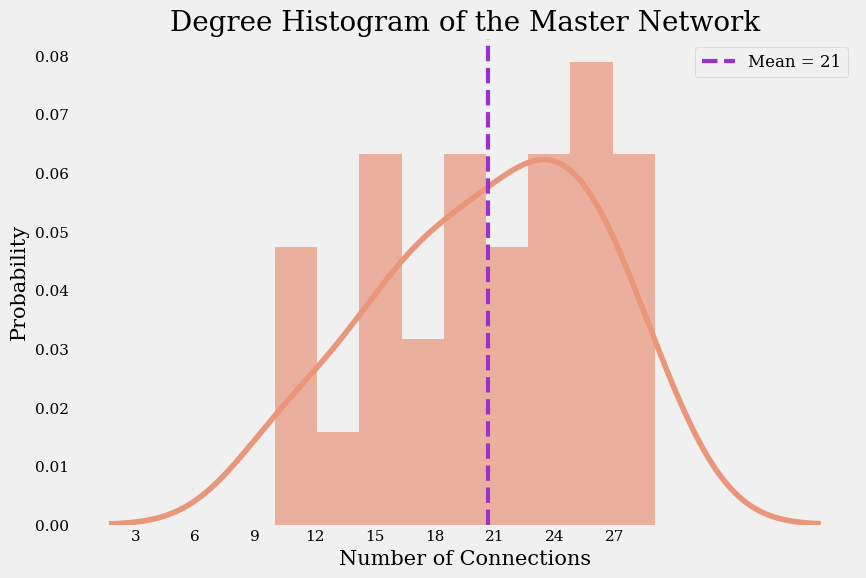

In [40]:
hist_plot(
    H_master,
    'Degree Histogram of the Master Network',
    bins=9,
    xticks=range(3, 30, 3)
)

To understand which assets are important in the network, we calculate **centrality metrics**:

  * **Degree Centrality**: number of connections. High-degree assets are similar to many others — possibly redundant.

  * **Closeness Centrality**: average distance to all other nodes. Indicates influence over the network.

  * **Betweenness Centrality**: number of shortest paths passing through a node. Measures control over information flow.

> Assets with high centrality may be “market movers,” sector leaders, or simply over-represented due to correlation structure.



# Risk

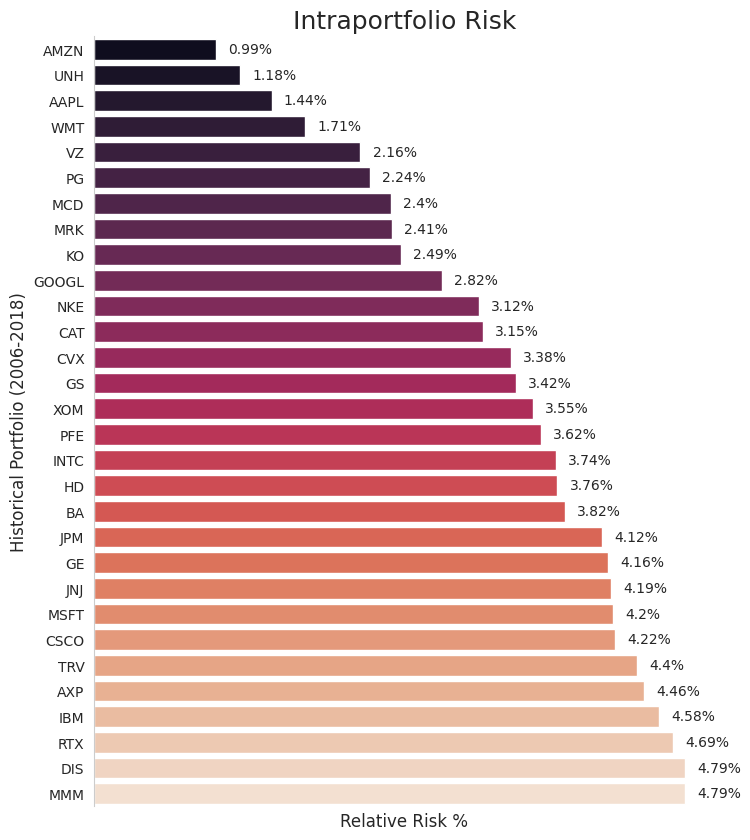

In [41]:
# calculates the communicability betweeness centrality and returns a dictionary
risk_alloc = nx.communicability_betweenness_centrality(H_master)

# converts the dictionary of degree centralities to a pandas series
risk_alloc = pd.Series(risk_alloc)

# normalizes the degree centrality
risk_alloc = risk_alloc / risk_alloc.sum()

# resets the index
risk_alloc.reset_index()

# converts series to a sorted DataFrame
risk_alloc = (
    pd.DataFrame({"Stocks": risk_alloc.index, "Risk Allocation": risk_alloc.values})
        .sort_values(by="Risk Allocation", ascending=True)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    # initializes figure
    plt.figure(figsize=(8,10))

    # plots a pretty seaborn barplot
    sns.barplot(x='Risk Allocation', y='Stocks', data=risk_alloc, palette="rocket")

    # removes spines
    sns.despine(right=True, top=True, bottom=True)

    # turns xticks off
    plt.xticks([])

    # labels the x axis
    plt.xlabel("Relative Risk %", size=12)

    # labels the y axis
    plt.ylabel("Historical Portfolio (2006-2018)", size=12)

    # figure title
    plt.title("Intraportfolio Risk", size=18)

    # iterates over the stocks (label) and their numerical index (i)
    for i, label in enumerate(list(risk_alloc.index)):

        # gets the height of each bar in the barplot
        height = risk_alloc.loc[label, 'Risk Allocation']

        # gets the relative risk as a percentage (the labels)
        label = (risk_alloc.loc[label, 'Risk Allocation']*100
                    ).round(2).astype(str) + '%'

        # annotates the barplot with the relative risk percentages
        plt.annotate(str(label), (height + 0.001, i + 0.15))



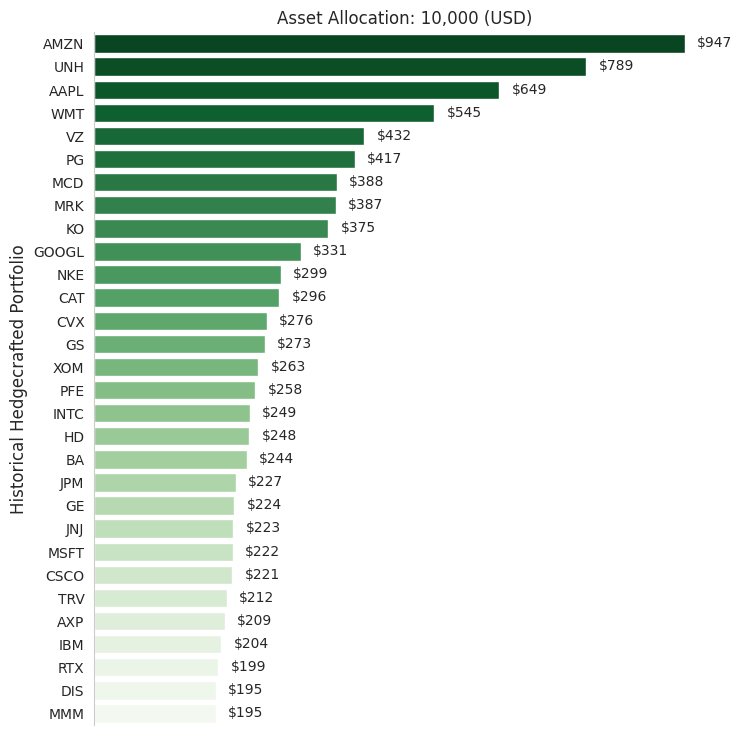

In [42]:
# calculates degree centrality and assigns it to investmnet_A
investment_A = nx.communicability_betweenness_centrality(H_master)

# calculates the inverse of the above and re-asigns it to investment_A as a pandas series
investment_A = 1 / pd.Series(investment_A)

# normalizes the above
investment_A = investment_A / investment_A.sum()

# resets the index
investment_A.reset_index()

# converts the above series to a sorted DataFrame
investment_A = (
    pd.DataFrame({"Stocks": investment_A.index, "Asset Allocation": investment_A.values})
        .sort_values(by="Asset Allocation", ascending=False)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    # initializes a figure
    plt.figure(figsize=(8,9))

    # plot a pretty seaborn barplot
    sns.barplot(x='Asset Allocation', y='Stocks', data=investment_A, palette="Greens_r")

    # despines the figure
    sns.despine(right=True, top=True, bottom=True)

    # turns xticks off
    plt.xticks([])

    # turns the x axis label off
    plt.xlabel('')

    # fig title
    plt.title("Asset Allocation: 10,000 (USD)", size=12)

    # y axis label
    plt.ylabel("Historical Hedgecrafted Portfolio", size=12)

    # captial to be allocated
    capital = 10000

    # iterates over the stocks (label) and their numerical indices (i)
    for i, label in enumerate(list(investment_A.index)):

        # gets the height of each bar
        height = investment_A.loc[label, 'Asset Allocation']

        # calculates the capital to be allocated
        label = (investment_A.loc[label, 'Asset Allocation'] * capital
                    ).round(2)

        # annotes the capital above each bar
        plt.annotate('${:,.0f}'.format(label), (height + 0.002, i + 0.15))

In [43]:
# DataFrame of the prices we buy stock at
df_buy_in = df_train_close_copy.loc['2018-12-31'].sort_index().to_frame('Buy In: 2018-12-31')

# Maximum Independent Set

Here we introduce a novel allocation approach:

* **Maximum Independent Set (MIS)**

The MIS is the largest subset of nodes with no direct edges between them.

In financial terms, it corresponds to the largest group of uncorrelated assets.

  This encourages maximal diversification without relying on optimization algorithms.

Once the MIS is identified, we allocate capital equally among these assets, or apply alternative weighting (e.g., inverse volatility).

    
>   Why it works:
  Traditional portfolios often overweight correlated assets, diminishing diversification. The MIS ensures true decorrelation at the selection stage.

>  Historical context:
  This approach links to risk parity, minimum spanning trees, and early work in econophysics, where networks were used to study market dynamics.



In [44]:
# a function to generate a random approximate MIS
### WARNING: rerunning kernel will produce different MISs
def generate_mis(G, sample_size, nodes=None):

    """Returns a random approximate maximum independent set.

    Parameters
    ----------
    G: NetworkX graph
       Undirected graph

    nodes: list, optional
        a list of nodes the approximate maximum independent set must contain.

    sample_size: int
        number of maximal independent sets sampled from

    Returns
    -------
    max_ind_set: list or None
        list of nodes in the apx-maximum independent set
        NoneType object if any two specified nodes share an edge

    """

    # list of maximal independent sets
    max_ind_set_list=[]

    # iterates from 0 to the number of samples chosen
    for i in range(sample_size):

        # for each iteration generates a random maximal independent set that contains
        # UnitedHealth and Amazon
        max_ind_set = nx.maximal_independent_set(G, nodes=nodes, seed=i)

        # if set is not a duplicate
        if max_ind_set not in max_ind_set_list:

            # appends set to the above list
            max_ind_set_list.append(max_ind_set)

        # otherwise pass duplicate set
        else:
            pass

    # list of the lengths of the maximal independent sets
    mis_len_list=[]

    # iterates over the above list
    for i in max_ind_set_list:

        # appends the lengths of each set to the above list
        mis_len_list.append(len(i))

    # extracts the largest maximal independent set, i.e., the maximum independent set (MIS)
    ## Note: this MIS may not be unique as it is possible there are many MISs of the same length
    max_ind_set = max_ind_set_list[mis_len_list.index(max(mis_len_list))]

    return max_ind_set



max_ind_set = generate_mis(H_master, nodes=['UNH', 'AMZN', 'VZ'], sample_size=100)
print(max_ind_set)

['UNH', 'AMZN', 'VZ', 'CAT', 'WMT']


In [45]:
# prices of shares to buy for the MIS
df_mis_buy_in = df_buy_in.loc[list(max_ind_set)]
df_mis_buy_in

Buy In: 2018-12-31
ticker                    
UNH             225.053177
AMZN             75.098503
VZ               38.957169
CAT             109.788841
WMT              28.089861

# Backtesting with Modern Portfolio Theory:

In [46]:
# calculates communicability betweeness centrality
weights = nx.communicability_betweenness_centrality(H_master)

# dictionary comprehension of communicability centrality for the maximum independent set
mis_weights = {key: weights[key] for key in list(max_ind_set)}


# a function to convert centrality scores to portfolio weights
def centrality_to_portfolio_weights(weights):

    """Returns a dictionary of portfolio weights.

    Parameters
    ----------
    weights: dictionary
        NetworkX centrality scores

    Returns
    -------
    portfolio weights: dictionary
        normalized inverse of chosen centrality measure

    """

    # iterates over the key, value pairs in the weights dict
    for key, value in weights.items():

        # takes the inverse of the communicability betweeness centrality of each asset
        weights[key] = 1/value

    # normalization parameter for all weights to add to 1
    norm = 1.0 / sum(weights.values())

    # iterates over the keys (stocks) in the weights dict
    for key in weights:

        # updates each key value to the normalized value and rounds to 3 decimal places
        weights[key] = round(weights[key] * norm, 3)

    return weights



print(centrality_to_portfolio_weights(weights))
print('\n')
print(centrality_to_portfolio_weights(mis_weights))

{'AAPL': 0.065, 'AMZN': 0.095, 'AXP': 0.021, 'BA': 0.024, 'CAT': 0.03, 'CSCO': 0.022, 'CVX': 0.028, 'DIS': 0.019, 'GE': 0.022, 'GOOGL': 0.033, 'GS': 0.027, 'HD': 0.025, 'IBM': 0.02, 'INTC': 0.025, 'JNJ': 0.022, 'JPM': 0.023, 'KO': 0.038, 'MCD': 0.039, 'MMM': 0.019, 'MRK': 0.039, 'MSFT': 0.022, 'NKE': 0.03, 'PFE': 0.026, 'PG': 0.042, 'RTX': 0.02, 'TRV': 0.021, 'UNH': 0.079, 'VZ': 0.043, 'WMT': 0.055, 'XOM': 0.026}


{'UNH': 0.262, 'AMZN': 0.315, 'VZ': 0.144, 'CAT': 0.098, 'WMT': 0.181}


In [47]:
# returns the number of shares to buy given the asset weights, prices, and capital to invest
alloc = discrete_allocation.DiscreteAllocation(
    weights,
    df_buy_in['Buy In: 2018-12-31'],
    total_portfolio_value=capital
)

# returns same as above but for the MIS
mis_alloc = discrete_allocation.DiscreteAllocation(
    mis_weights,
    df_mis_buy_in['Buy In: 2018-12-31'],
    total_portfolio_value=capital
)

In [48]:
alloc = alloc.greedy_portfolio()[0]
mis_alloc = mis_alloc.greedy_portfolio()[0]

In [49]:
# converts above shares to a pandas series
alloc_series = pd.Series(alloc, name='Shares')

# names the series
alloc_series.index.name = 'Assets'

# resets index, prints assets with the shares we buy
alloc_series.reset_index
print(alloc_series)

print('\n')

# does same as above but for the MIS
mis_alloc_series = pd.Series(mis_alloc, name='MIS Shares')
mis_alloc_series.index.name = 'Assets'
mis_alloc_series.reset_index
print(mis_alloc_series)

Assets
AMZN     13
UNH       4
AAPL     17
WMT      19
VZ       11
PG        5
MCD       3
MRK       6
KO       10
GOOGL     6
CAT       3
NKE       4
CVX       3
GS        2
PFE       8
XOM       5
HD        2
INTC      6
BA        1
JPM       3
CSCO      6
GE        6
JNJ       2
MSFT      2
AXP       2
TRV       2
IBM       2
RTX       3
DIS       2
MMM       1
Name: Shares, dtype: int64


Assets
AMZN    41
UNH     12
WMT     65
VZ      36
CAT      9
Name: MIS Shares, dtype: int64


In [50]:
# converts Hedgecraft shares series to a DataFrame
df_alloc = alloc_series.sort_index().to_frame('Shares')

# converts Hedgecraft MIS shares series to a DataFrame
df_mis_alloc = mis_alloc_series.sort_index().to_frame('MIS Shares')

In [51]:
# imports a tool to calculate the mean historical return from a
# portfolio optimization package called pypfopt
from pypfopt.expected_returns import mean_historical_return

# returns the mean historical return of the training data
mu = mean_historical_return(df_train_close_copy)

# computes the covariance matrix
S = df_train_close_copy.cov()

In [52]:
# imports the efficient frontier model for asset allocation
from pypfopt.efficient_frontier import EfficientFrontier

# runs the efficient frontier (EF) algo
ef = EfficientFrontier(mu, S)

# computes portfolio weights subject to minimizing the volatility (portfolio std)
weights_ef = ef.min_volatility()

# rounds and prints the weights
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('AXP', 0.0), ('BA', 0.0), ('CAT', 0.0), ('CSCO', 0.06988), ('CVX', 0.0), ('DIS', 0.0), ('GE', 0.01514), ('GOOGL', 0.0), ('GS', 0.0), ('HD', 0.0), ('IBM', 0.0), ('INTC', 0.0), ('JNJ', 0.0), ('JPM', 0.0), ('KO', 0.0), ('MCD', 0.0), ('MMM', 0.0), ('MRK', 0.0), ('MSFT', 0.0), ('NKE', 0.0), ('PFE', 0.0), ('PG', 0.0), ('RTX', 0.0), ('TRV', 0.0), ('UNH', 0.0), ('VZ', 0.0), ('WMT', 0.91498), ('XOM', 0.0)])


In [53]:
# returns the number of shares to buy given asset prices, weights, and capital to invest for the EF model
ef_alloc = discrete_allocation.DiscreteAllocation(
    weights_ef,
    df_buy_in['Buy In: 2018-12-31'],
    total_portfolio_value=capital
)

In [54]:
ef_alloc = ef_alloc.greedy_portfolio()[0]

In [ ]:
# converts EF shares to a pandas series
ef_alloc_series = pd.Series(ef_alloc, name='Shares')

# names the series
ef_alloc_series.index.name = 'Assets'

# resets index, prints assets and the shares we buy
ef_alloc_series.reset_index

In [56]:
# converts EF shares series to a DataFrame
df_ef_alloc = ef_alloc_series.sort_index().to_frame('Shares')

In [57]:
# total capital invested in the Hedgecraft portfolio after buying shares
capital = (df_buy_in['Buy In: 2018-12-31']*df_alloc['Shares']).sum()

# total capital invested in Efficient Frontier portfolio after buying shares
ef_capital = (df_buy_in['Buy In: 2018-12-31']*df_ef_alloc['Shares']).sum()

# total capital invested in Hedgecraft MIS portfolio after buying shares
mis_capital = (df_mis_buy_in['Buy In: 2018-12-31']*df_mis_alloc['MIS Shares']).sum()


# function to compute the cumulative returns of a portfolio
def cumulative_returns(shares_allocation, capital, test_data):

    """Returns the cumulative returns of a portfolio.

    Parameters
    ----------
    shares_allocation: DataFrame
        number of shares allocated to each asset in the portfolio

    capital: float
        total amount of money invested in the portfolio

    test_data: DataFrame
        daily closing prices of portfolio assets

    Returns
    -------
    cumulative_daily_returns: Series
        cumulative daily returns of the portfolio

    """

    # list of DataFrames of cumulative returns for each stock
    daily_returns = []

    # iterates over every stock in the portfolio
    for stock in shares_allocation.index:

        # multiples shares by share prices in the validation dataset
        daily_returns.append(shares_allocation.loc[stock].values * test_data[stock])

    # concatenates every DataFrame in the above list to a single DataFrame
    daily_returns_df = pd.concat(daily_returns, axis=1).reset_index()

    # sets the index as the date
    daily_returns_df.set_index("Date", inplace=True)

    # adds the cumulative returns for every stock
    cumulative_daily_returns = daily_returns_df.sum(axis=1)

    # returns the cumulative daily returns of the portfolio
    return cumulative_daily_returns



# Hedgecraft cumulative daily returns
total_daily_returns = cumulative_returns(
    df_alloc,
    capital,
    df_validate
).rename('Hedgecraft Cumulative Daily Returns')


# Efficient Frontier cumulative daily returns
ef_total_daily_returns = cumulative_returns(
    df_ef_alloc,
    ef_capital,
    df_validate
).rename('EF Cumulative Daily Returns')


# Hedgecraft MIS cumulative daily returns
mis_total_daily_returns = cumulative_returns(
    df_mis_alloc,
    mis_capital,
    df_validate
).rename('MIS Cumulative Daily Returns')

# function to compute daily return on investment (roi)
def portfolio_daily_roi(shares_allocation, capital, test_data):

    """Returns the daily return on investment.

    Parameters
    ----------
    shares_allocation: DataFrame
        number of shares allocated to each asset

    capital: float
        total amount of money invested in the portfolio

    test_data: DataFrame
        daily closing prices of each asset

    Returns
    -------
    daily_roi: Series
        daily return on investment of the portfolio

    """

    # computes the cumulative returns
    cumulative_daily_returns = cumulative_returns(
        shares_allocation,
        capital,
        test_data
    )

    # calculates daily return on investment
    daily_roi = cumulative_daily_returns.apply(
        lambda returns: ((returns - capital) / capital)*100
    )

    # returns the daily return on investment
    return daily_roi



# Hedgecraft daily return on investment
daily_roi = portfolio_daily_roi(
    df_alloc,
    capital,
    df_validate
).rename('Hedgecraft Daily Returns')


# Efficient Frontier daily return on investment
ef_daily_roi = portfolio_daily_roi(
    df_ef_alloc,
    ef_capital,
    df_validate
).rename('EF Daily Returns')


# Hedgecraft MIS daily return on investment
mis_daily_roi = portfolio_daily_roi(
    df_mis_alloc,
    mis_capital,
    df_validate
).rename('MIS Daily Returns')

In [58]:
# imports datetime manipluation library
from datetime import datetime

# function to extract the end of year returns
def end_of_year_returns(model_roi, return_type, start, end):

    """Returns the end of year returns of a portfolio.

    Parameters
    ----------
    model_roi: Series
        portoflio returns on investment

    return_type: string
        'returns': returns roi
        'returns_rate': returns rate of returns

    start: int
        starting year to extract last trading day from

    end: int
        ending year to extract last trading day from

    Returns
    -------
    end_of_year_returns: dictionary
        each year's returns or rate of returns

    """

    # converts index of datetimes to a list of strings
    dates = model_roi.index.astype('str').tolist()

    # list comprehension of a string of dates between the
    # start and end dates
    years = [str(x) for x in range(start, end + 1)]

    # generates an empty list of lists for each year
    end_year_dates = [[] for _ in range(len(years))]

    # iterates over every date in the roi series
    for date in dates:

        # iterates over every year in the years list
        for year in years:

            # iterates over every year in each date
            if year in date:

                # converts each date string to a datime object
                datetime_object = datetime.strptime(date, '%Y-%m-%d')

                # appends each date to its corresponding year in the years list
                (end_year_dates[years.index(year)]
                    .append(datetime.strftime(datetime_object, '%Y-%m-%d')))

    # finds the last date in each year
    end_year_dates = [max(x) for x in end_year_dates]

    # gets the rounded end of year returns
    returns = [round(model_roi[date], 1) for date in end_year_dates]

    # shifts the returns list by 1 and appends 0 to the beginning of the list
    return_rates = [0] + returns[:len(returns)-1]
    """Example: [a, b, c] -> [0, a, b]"""

    # converts returns list to an array
    returns_arr = np.array(returns)

    # converts the return_rates list to an array
    return_rates_arr = np.array(return_rates)

    # calculates the rounded rate of returns
    return_rates = [round(x, 1) for x in list(returns_arr - return_rates_arr)]
    """Example: [a, b, c] - [0, a, b] = [a, b-a, c-b]"""

    # dictionary with the years as keys and returns as values
    returns = dict(zip(years, returns))

    # dictionary with the years as keys and return rates as values
    return_rates = dict(zip(years, return_rates))

    if return_type == 'returns':
        return returns

    if return_type == 'return_rates':
        return return_rates


# Hedgecraft annual return rates
returns_dict = end_of_year_returns(
    daily_roi,
    'return_rates',
    2019,
    2022
)

# Efficient Frontier annual return rates
ef_returns_dict = end_of_year_returns(
    ef_daily_roi,
    'return_rates',
    2019,
    2022
)

# Hedgecraft MIS annual return rates
mis_returns_dict = end_of_year_returns(
    mis_daily_roi,
    'return_rates',
    2019,
    2022
)

# Hedgecraft annual returns
tot_returns_dict = end_of_year_returns(
    daily_roi,
    'returns',
    2019,
    2022
)

# Efficient Frontier annual returns
ef_tot_returns_dict = end_of_year_returns(
    ef_daily_roi,
    'returns',
    2019,
    2022
)

# Hedgecraft MIS annual returns
mis_tot_returns_dict = end_of_year_returns(
    mis_daily_roi,
    'returns',
    2019,
    2022
)

In [59]:
# function to calculate avg annual portfolio returns
def avg_annual_returns(end_of_year_returns, mstat):

    """Returns average annual returns.

    Parameters
    ----------
    end_of_year_returns: dictionary
        annual returns

    mstat: string
        'arithmetic': returns the arithmetic mean
        'geometric': returns the geometric mean

    Returns
    -------
    average annual returns: float

    """

    # imports mean stats
    from scipy.stats import mstats

    # converts returns dict to an array (in decimal fmt)
    returns_arr = np.array(list(end_of_year_returns.values()))/100

    if mstat == 'geometric':

        # calculates the geometric mean
        gmean_returns = (mstats.gmean(1 + returns_arr) - 1)*100

        return round(gmean_returns, 2)

    if mstat == 'arithmetic':

        # calculates the arithmetic mean
        mean_returns = np.mean(returns_arr)

        return round(mean_returns, 2)


# Hedgecraft avg annual returns
gmean_returns = avg_annual_returns(returns_dict, mstat='geometric')

# Efficient Frontier avg annual returns
ef_gmean_returns = avg_annual_returns(ef_returns_dict, mstat='geometric')

# Hedgecraft MIS avg annual returns
mis_gmean_returns = avg_annual_returns(mis_returns_dict, mstat='geometric')

print(gmean_returns)
print(ef_gmean_returns)
print(mis_gmean_returns)



16.17
9.6
14.69


In [60]:
# function to calculate annualized portoflio standard deviation
def portfolio_std(weights, test_data):

    """Returns annualized portfolio volatility.

    Parameters
    ----------
    weights: dictionary
        portfolio weights

    test_data: DataFrame
        validation data set

    Returns
    -------
    portfolio_std_dev: float
        annualized portfolio standard deviaion

    """

    # computes daily change in returns from 2015-2017
    daily_ret_delta = test_data.pct_change()

    # computes the covariance matrix of the above
    cov_matrix = daily_ret_delta.cov()

    # initializes weights
    weights_list = []

    # iterates over weights dict and appends above list
    for key, value in weights.items():
        weights_list.append(value)

    # converts weights list to numpy array
    weights_arr = np.array(weights_list)

    # calculates the annualized portfolio standard deviation from 2015-2017 in pct format
    portfolio_std_dev = np.sqrt(
        np.dot(
            weights_arr.T,
            np.dot(
                cov_matrix,
                weights_arr
            )
        )
    )*np.sqrt(252)*100

    return round(portfolio_std_dev, 2)


# function to calculate annualized portfolio standard deviation with a
# maximum independent set parameter
def mis_portfolio_std(weights, test_data, maximum_independent_set):

    """Returns annualized portfolio volatility.

    Parameters
    ----------
    weights: dictionary
        portfolio weights

    test_data: DataFrame
        validation data set

    maximum_independent_set: list
        largest list of assets such that no two are adjacent

    Returns
    -------
    portfolio_std_dev: float
        annualized portfolio standard deviation

    """

    # computes daily change in returns from 2015-2017
    daily_ret_delta = test_data[maximum_independent_set].pct_change()

    # computes the covariance matrix
    cov_matrix = daily_ret_delta.cov()

    # initializes weights list
    weights_list = []

    # iterates over weights dict and appends above list
    for key, value in weights.items():
        weights_list.append(value)

    # converts weights list to numpy array
    weights_arr = np.array(weights_list)

    # calculates portfolio standard deviation from 2015-2017
    portfolio_std_dev = np.sqrt(
        np.dot(
            weights_arr.T,
            np.dot(
                cov_matrix,
                weights_arr
            )
        )
    )*np.sqrt(252)*100

    return round(portfolio_std_dev, 2)


# Hedgecraft annualized volatility
portfolio_std_dev = portfolio_std(
    weights=weights,
    test_data=df_validate
)

# Efficient Frontier annualized volatility
ef_portfolio_std_dev = portfolio_std(
    weights=weights_ef,
    test_data=df_validate
)

# Hedgecraft MIS annualized volatility
mis_portfolio_std_dev = mis_portfolio_std(
    weights=mis_weights,
    test_data=df_validate,
    maximum_independent_set=max_ind_set
)

print(portfolio_std_dev)
print(ef_portfolio_std_dev)
print(mis_portfolio_std_dev)

21.38
22.47
20.9


In [61]:
# function to compute the Sharpe ratio
def portfolio_sharpe_ratio(avg_annual_returns, portfolio_std, risk_free_rate):

    """Returns Sharpe ratio.

    Parameters
    ----------
    avg_annual_returns: float
        portoflio avg annual returns

    portfolio_std: float
        annualized portfolio volatility

    risk_free_rate: float
        usually taken as the avg 10-year treasury rate over investment period

    Returns
    -------
    portfolio_std_dev: float
        annualized portfolio standard deviaion

    """

    # calculates the Sharpe ratio
    sharpe_ratio = (avg_annual_returns - risk_free_rate) / portfolio_std

    return round(sharpe_ratio, 2)

# Sharpe ratio of the Hedgecraft portfolio
## we use a 2% risk free rate
sharpe_ratio = portfolio_sharpe_ratio(
    gmean_returns,
    portfolio_std_dev,
    2
)

# Sharpe ratio of the Markowitz portfolio
ef_sharpe_ratio = portfolio_sharpe_ratio(
    ef_gmean_returns,
    ef_portfolio_std_dev,
    2
)

# Sharpe ratio of the Hedgecraft MIS portfolio
mis_sharpe_ratio = portfolio_sharpe_ratio(
    mis_gmean_returns,
    mis_portfolio_std_dev,
    2
)

print(sharpe_ratio)
print(ef_sharpe_ratio)
print(mis_sharpe_ratio)

0.66
0.34
0.61


In [62]:
# function to compute the 252-day daily rolling maximum
def daily_rolling_max(cumulative_returns, window=252, min_periods=1):

    """Returns the daily running 252-day maximum.

    Parameters
    ----------
    cumulative_returns: Series
        portoflio's cumulative returns

    window: int, default 252
        size of the moving window.

    min_periods: int
        minimum number of observations in window required to have a value

    Returns
    -------
    daily_rolling_max: Series

    """

    return cumulative_returns.rolling(
        window=window,
        min_periods=min_periods
    ).max()


# function to compute the 252-day rolling drawdown
def daily_rolling_drawdown(cumulative_returns, rolling_max):

    """Returns the daily running 252-day drawdown.

    Parameters
    ----------
    cumulative_returns: Series
        portoflio's cumulative returns

    rolling_max: Series
        rolling 252-day maximum

    Returns
    -------
    daily_rolling_drawdown: Series

    """

    return (cumulative_returns / rolling_max) - 1


# function to compute the 252-day maximum daily drawdown
def max_daily_rolling_drawdown(daily_drawdown, window=252, min_periods=1):

    """Returns the daily running 252-day maximum daily drawdown.

    Parameters
    ----------
    daily_drawdown: Series
       daily rolling 252-day drawdown

    window: int, default 252
        size of the moving window.

    min_periods: int
        minimum number of observations in window required to have a value

    Returns
    -------
    max_daily_rolling_drawdown: Series

    """

    return daily_drawdown.rolling(
        window=window,
        min_periods=min_periods
    ).min()


# function to compute the lifetime maximum drawdown
def lifetime_max_drawdown(daily_drawdown):

    """Returns the lifetime maximum drawdown.

    Parameters
    ----------
    daily_drawdown: Series
       daily rolling 252-day drawdown

    Returns
    -------
    lifetime_max_drawdown: float
        largest amount of money lost

    """

    return round(daily_drawdown.min()*100, 2)


# Hedgecraft 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
roll_max = daily_rolling_max(total_daily_returns)
daily_drawdown = daily_rolling_drawdown(
    total_daily_returns,
    roll_max
)
max_daily_drawdown = max_daily_rolling_drawdown(daily_drawdown)
max_drawdown = lifetime_max_drawdown(daily_drawdown)

# Efficient Frontier 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
ef_roll_max = daily_rolling_max(ef_total_daily_returns)
ef_daily_drawdown = daily_rolling_drawdown(
    ef_total_daily_returns,
    ef_roll_max
)
ef_max_daily_drawdown = max_daily_rolling_drawdown(ef_daily_drawdown)
ef_max_drawdown = lifetime_max_drawdown(ef_daily_drawdown)

# Hedgecraft MIS 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
mis_roll_max = daily_rolling_max(mis_total_daily_returns)
mis_daily_drawdown = daily_rolling_drawdown(
    mis_total_daily_returns,
    mis_roll_max
)
mis_max_daily_drawdown = max_daily_rolling_drawdown(mis_daily_drawdown)
mis_max_drawdown = lifetime_max_drawdown(mis_daily_drawdown)

In [63]:
# calculates returns over lifetime maximum drawdown
def returns_over_max_drawdown(tot_returns_dict, year, lifetime_maximum_drawdown):

    """Returns the lifetime maximum drawdown.

    Parameters
    ----------
    tot_returns_dict: dictionary
       cumulative annual portfolio returns

    year: int

    lifetime_maximum_drawdown: float
        largest amount of money lost

    Returns
    -------
    returns_over_max_drawdown: float
        cumulative returns divded by largest sum of money lost

    """

    return round(tot_returns_dict[year] / abs(lifetime_maximum_drawdown), 2)


# Hedgecraft risk-return ratio
risk_return_ratio = returns_over_max_drawdown(
    tot_returns_dict,
    '2022',
    max_drawdown
)

# Efficient Frontier risk-return ratio
ef_risk_return_ratio = returns_over_max_drawdown(
    ef_tot_returns_dict,
    '2022',
    ef_max_drawdown
)

# Hedgecraft MIS risk-return ratio
mis_risk_return_ratio = returns_over_max_drawdown(
    mis_tot_returns_dict,
    '2022',
    mis_max_drawdown
)

print(risk_return_ratio)
print(ef_risk_return_ratio)
print(mis_risk_return_ratio)



2.41
1.8
3.05


In [65]:
# function to calculate the growth-risk ratio
def portfolio_growth_risk(avg_annual_returns, max_daily_rolling_drawdown):

    """Returns the growth-risk ratio.

        Parameters
        ----------
        avg_annual_returns: float
           average annual returns

        max_daily_rolling_drawdown: Series
            252-day rolling maximum daily drawdown

        Returns
        -------
        portfolio_growth_risk: float
            average annual returns divided by average rolling max daily drawdown

    """

    return round(avg_annual_returns / abs(max_daily_rolling_drawdown.mean()*100), 2)

# growth-risk ratios for each model
growth_risk_ratio = portfolio_growth_risk(gmean_returns, max_daily_drawdown)
ef_growth_risk_ratio = portfolio_growth_risk(ef_gmean_returns, ef_max_daily_drawdown)
mis_growth_risk_ratio = portfolio_growth_risk(mis_gmean_returns, mis_max_daily_drawdown)

print(growth_risk_ratio)
print(ef_growth_risk_ratio)
print(mis_growth_risk_ratio)

1.08
0.78
1.13


In [66]:
def collect_results(model):

    if model == 'hedgecraft':

        collection = [[], [], []]

        collection[0].append([str(x) + '%' for x in list(returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(tot_returns_dict.values())])
        collection[2].append([str(x) + '%' for x in [gmean_returns, portfolio_std_dev, max_drawdown]])
        collection[2].append([sharpe_ratio, risk_return_ratio, growth_risk_ratio])

        return collection

    if model == 'efficient_frontier':

        collection = [[], [], []]

        collection[0].append([str(x) + '%' for x in list(ef_returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(ef_tot_returns_dict.values())])

        collection[2].append([str(x) + '%' for x in [
            ef_gmean_returns,
            ef_portfolio_std_dev,
            ef_max_drawdown]
                             ]
                            )

        collection[2].append([ef_sharpe_ratio, ef_risk_return_ratio, ef_growth_risk_ratio])

        return collection

    if model == 'hedgecraft_mis':

        collection = [[], [], []]

        collection[0].append([str(x) + '%' for x in list(mis_returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(mis_tot_returns_dict.values())])

        collection[2].append([str(x) + '%' for x in [
            mis_gmean_returns,
            mis_portfolio_std_dev,
            mis_max_drawdown]
                             ]
                            )

        collection[2].append([mis_sharpe_ratio, mis_risk_return_ratio, mis_growth_risk_ratio])

        return collection

yearly_return_rates = collect_results(model = 'hedgecraft')[0][0]
yearly_returns = collect_results(model='hedgecraft')[1][0]

summary_stats = (collect_results(model='hedgecraft')[2][0]
    + collect_results(model='hedgecraft')[2][1])

ef_yearly_return_rates = collect_results(model = 'efficient_frontier')[0][0]
ef_yearly_returns = collect_results(model='efficient_frontier')[1][0]
ef_summary_stats = (collect_results(model='efficient_frontier')[2][0]
    + collect_results(model='efficient_frontier')[2][1])

mis_yearly_return_rates = collect_results(model = 'hedgecraft_mis')[0][0]
mis_yearly_returns = collect_results(model='hedgecraft_mis')[1][0]
mis_summary_stats = (collect_results(model='hedgecraft_mis')[2][0]
    + collect_results(model='hedgecraft_mis')[2][1])

dow_yearly_return_rates=[22.34, 7.25, 18.73, -11.39]
dow_yearly_return_rates=[str(x) + '%' for x in dow_yearly_return_rates]
sp500_yearly_return_rates=[28.88, 16.26, 26.89,-15.58]
sp500_yearly_return_rates=[str(x) + '%' for x in sp500_yearly_return_rates]

In [67]:
# dictionary summary of model performances
returns_summary = {
                    'Hedgecraft Returns': yearly_returns,
                    'Hedgecraft MIS Returns': mis_yearly_returns,
                    'Efficient Frontier Returns': ef_yearly_returns,
                    'Dow Return Rates': dow_yearly_return_rates,
                    'S&P500 Return Rates': sp500_yearly_return_rates,
                    'Hedgecraft Return Rates': yearly_return_rates,
                    'Hedgecraft MIS Return Rates': mis_yearly_return_rates,
                    'Efficient Frontier Return Rates': ef_yearly_return_rates,
}

# converts above dict to a DataFrame
returns_summary = pd.DataFrame.from_dict(returns_summary)

# relabels indices as years
returns_summary = returns_summary.rename(index={0:'2019', 1:'2020', 2:'2021',3:'2022'});

# dictionary of stats
backtest_stats = {
                  'Hedgecraft': summary_stats,
                  'Hedgecraft MIS': mis_summary_stats,
                  'Efficient Frontier': ef_summary_stats
}

# converts above dict to DataFrame
backtest_stats =  pd.DataFrame.from_dict(backtest_stats)

# renames the indices
backtest_stats = backtest_stats.rename(index={
                                        0:'Avg Annual Rate of Returns',
                                        1:'Annual Volatility',
                                        2:'Maximum Drawdown',
                                        3:'Annualized Sharpe Ratio',
                                        4:'Returns Over Maximum Drawdown',
                                        5:'Growth-Risk Ratio'
                                }
);

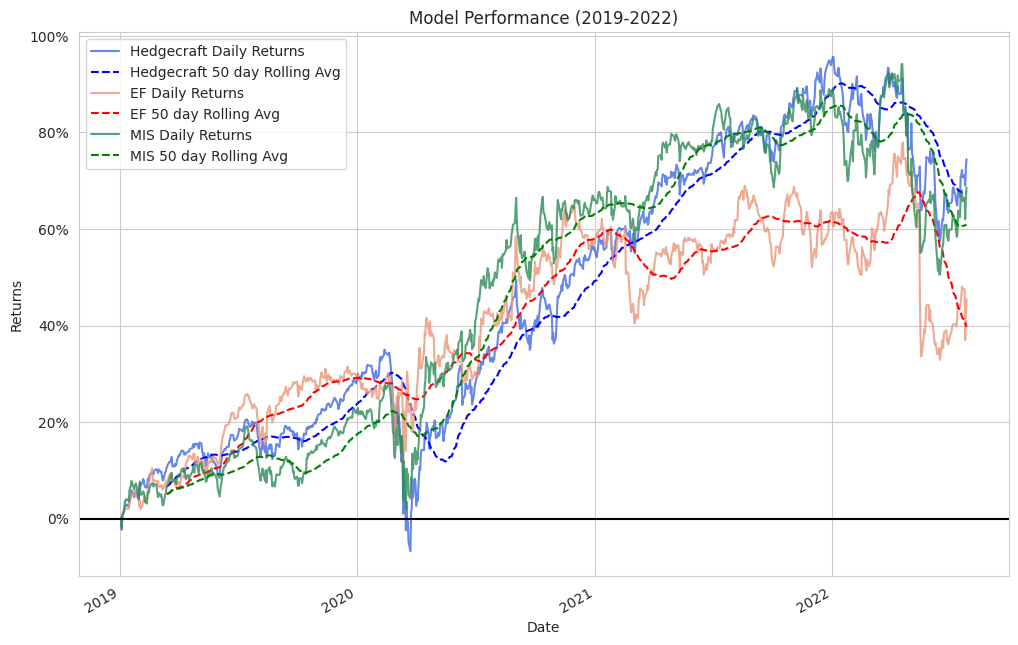

In [68]:
rolling_50d_avg = (daily_roi.rename('Hedgecraft 50 day Rolling Avg')
                        .rolling(50)
                        .mean()
)

# returns Efficient Frontier 50 day moving avg
ef_rolling_50d_avg = (ef_daily_roi.rename('EF 50 day Rolling Avg')
                            .rolling(50)
                            .mean()
)

# returns Hedgecraft MIS 50 day moving avg
mis_rolling_50d_avg = (mis_daily_roi.rename('MIS 50 day Rolling Avg')
                                .rolling(50)
                                .mean()
)

with sns.axes_style('whitegrid'):
    # initializes figure and axis
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    # gets xtick postions for datetime objects, set minimum number of xticks to 3
    xtick_locator = AutoDateLocator(minticks=3)

    # aesthetically formats xticks
    xtick_formatter = AutoDateFormatter(xtick_locator)


    # returns pretty seaborn plot of hedgecraft returns and its 50 day rolling avg
    daily_roi.plot(color='royalblue', alpha=0.8)
    rolling_50d_avg.plot(color='blue', ls='dashed')

    # returns pretty seaborn plot of EF returns and its 50 day rolling avg
    ef_daily_roi.plot(color='darksalmon', alpha=0.8)
    ef_rolling_50d_avg.plot(color='red', ls='dashed')

    # returns pretty seaborn plot of hedgecraft MIS returns and its 50 day rolling avg
    mis_daily_roi.plot(color='seagreen', alpha=0.8)
    mis_rolling_50d_avg.plot(color='green', ls='dashed')

    # renders xticks, sets ylabel, and turns legend on
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_formatter)
    ax.set_title('Model Performance (2019-2022)')
    ax.set_ylabel('Returns')
    ax.legend()

    # gets ytick labels and converts to pct format
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in vals])

    # draws a horizontal line at 0, turns grid on
    plt.axhline(0, color='black');
    plt.tick_params(left=False, bottom=False)

In [ ]:
returns_summary

Hedgecraft Returns Hedgecraft MIS Returns Efficient Frontier Returns  \
2019              28.3%                  21.3%                      29.3%   
2020              56.3%                  64.2%                      56.8%   
2021              93.9%                  95.2%                      63.4%   
2022              74.5%                  75.3%                      45.5%   

     Dow Return Rates S&P500 Return Rates Hedgecraft Return Rates  \
2019           22.34%              28.88%                   28.3%   
2020            7.25%              16.26%                   28.0%   
2021           18.73%              26.89%                   37.6%   
2022          -11.39%             -15.58%                  -19.4%   

     Hedgecraft MIS Return Rates Efficient Frontier Return Rates  
2019                       21.3%                           29.3%  
2020                       42.9%                           27.5%  
2021                       31.0%                            6.6%  
2022                      -19.9%                          -17.9%

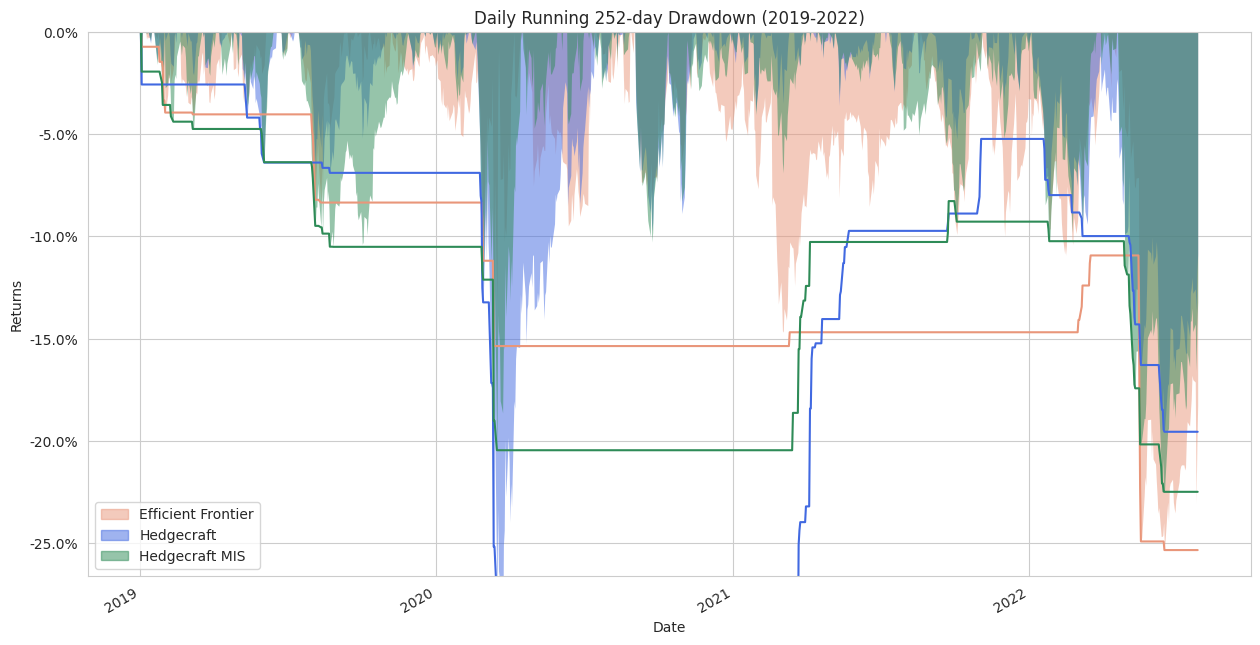

In [69]:
with sns.axes_style('whitegrid'):
    # initializes figure and axis
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)

    # gets xtick postions for datetime objects, set minimum number of xticks to 3
    xtick_locator = AutoDateLocator(minticks=3)

    # aesthetically formats xticks
    xtick_formatter = AutoDateFormatter(xtick_locator)

    ef_daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='darksalmon')
    ef_max_daily_drawdown.plot(color='darksalmon')

    daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='royalblue')
    max_daily_drawdown.plot(color='royalblue')

    mis_daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='seagreen')
    mis_max_daily_drawdown.plot(color='seagreen')

    # renders xticks, sets ylabel, and turns legend on
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_formatter)

    ax.set_ylabel('Returns')

    # sets legend patches color and labels
    ef_patch = mpatches.Patch(color='darksalmon', label='Efficient Frontier', alpha=0.5)
    patch = mpatches.Patch(color='royalblue', label='Hedgecraft', alpha=0.5)
    mis_patch = mpatches.Patch(color='seagreen', label='Hedgecraft MIS', alpha=0.5)

    # turns legend on with patches
    plt.legend(handles=[ef_patch, patch, mis_patch])

    plt.tick_params(left=False, bottom=False)
    plt.title('Daily Running 252-day Drawdown (2019-2022)')

     # gets ytick labels and converts to pct format
    vals = ax.get_yticks()
    ax.set_yticklabels([str(round(x*100,2)) + '%' for x in vals])

In [70]:
backtest_stats

Hedgecraft Hedgecraft MIS Efficient Frontier
Avg Annual Rate of Returns        16.17%         14.69%               9.6%
Annual Volatility                 21.38%          20.9%             22.47%
Maximum Drawdown                 -30.95%        -22.49%            -25.34%
Annualized Sharpe Ratio             0.66           0.61               0.34
Returns Over Maximum Drawdown       2.41           3.05                1.8
Growth-Risk Ratio                   1.08           1.13               0.78

In [71]:
# probability of Hedgecraft losing money
prob_lose_money = (daily_roi[daily_roi < 0].shape[0]
                       / daily_roi.shape[0]
)

# probability of EF losing money
ef_prob_lose_money = (ef_daily_roi[ef_daily_roi < 0].shape[0]
                          / ef_daily_roi.shape[0]
)

# probability of Hedgecraft MIS losing money
mis_prob_lose_money = (mis_daily_roi[mis_daily_roi < 0].shape[0]
                           / mis_daily_roi.shape[0]
)

# Hedgecraft rolling 30 day avg
rolling_30d_avg = (daily_roi.rename('Hedgecraft 30 day Rolling Avg')
                   .rolling(30)
                   .mean()
)

# EF rolling 30 day avg
ef_rolling_30d_avg = (ef_daily_roi.rename('EF 30 day Rolling Avg')
                      .rolling(30)
                      .mean()
)

# Hedgecraft MIS rolling 30 day avg
mis_rolling_30d_avg = (mis_daily_roi.rename('MIS 30 day Rolling Avg')
                       .rolling(30)
                       .mean()
)

# Hedgecraft rolling 90 day avg
rolling_90d_avg = (daily_roi.rename('Hedgecraft 90 day Rolling Avg')
                   .rolling(90)
                   .mean()
)

# EF rolling 90 day avg
ef_rolling_90d_avg = (ef_daily_roi.rename('EF 90 day Rolling Avg')
                      .rolling(90)
                      .mean()
)

# Hedgecraft MIS rolling 90 day avg
mis_rolling_90d_avg = (mis_daily_roi.rename('MIS 90 day Rolling Avg')
                       .rolling(90)
                       .mean()
)

# Hedgecraft list of rolling avgs
rolling_avg_list = [rolling_30d_avg, rolling_50d_avg, rolling_90d_avg]

# EF list of rolling avgs
ef_rolling_avg_list = [ef_rolling_30d_avg, ef_rolling_50d_avg, ef_rolling_90d_avg]

# Hedgecraft MIS list of rolling avgs
mis_rolling_avg_list = [mis_rolling_30d_avg, mis_rolling_50d_avg, mis_rolling_90d_avg]

# Hedgecraft probabilities of falling below 30, 50, and 90 day rolling averages
prob_below_rolling_avgs = []
for i in rolling_avg_list:
    (prob_below_rolling_avgs.append(daily_roi[daily_roi < i].shape[0]
                                    / daily_roi.shape[0]))

# Efficient Frontier probabilities of falling below 30, 50, and 90 day rolling averages
ef_prob_below_rolling_avgs = []
for i in ef_rolling_avg_list:
    (ef_prob_below_rolling_avgs.append(ef_daily_roi[ef_daily_roi < i].shape[0]
                                       / ef_daily_roi.shape[0]))

# Hedgecraft MIS probabilities of falling below 30, 50, and 90 day rolling averages
mis_prob_below_rolling_avgs = []
for i in mis_rolling_avg_list:
    (mis_prob_below_rolling_avgs.append(mis_daily_roi[mis_daily_roi < i].shape[0]
                                        / mis_daily_roi.shape[0]))

# worst day for the Hedgecraft model
max_loss = min(daily_roi)

# worst day for the Efficient Frontier model
ef_max_loss = min(ef_daily_roi)

# worst day for the Hedgecraft MIS model
mis_max_loss = min(mis_daily_roi)

# avg amount of money lost by Hedgecraft when returns fell below 0%
mean_loss = daily_roi[daily_roi < 0].mean()

# avg amount of money lost by EF when returns fell below 0%
ef_mean_loss = ef_daily_roi[ef_daily_roi < 0].mean()

# avg amount of money lost by Hedgecraft MIS when returns fell below 0%
mis_mean_loss = mis_daily_roi[mis_daily_roi < 0].mean()

# Hedgecraft distribution of returns statistics
dist_stats = [
                prob_lose_money*100,
                max_loss,
                mean_loss,
                prob_below_rolling_avgs[0]*100,
                prob_below_rolling_avgs[1]*100,
                prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
dist_stats = [str(round(x, 2)) + '%' for x in dist_stats]

# Ef distribution of returns statistics
ef_dist_stats = [
                    ef_prob_lose_money*100,
                    ef_max_loss, ef_mean_loss,
                    ef_prob_below_rolling_avgs[0]*100,
                    ef_prob_below_rolling_avgs[1]*100,
                    ef_prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
ef_dist_stats = [str(round(x, 2)) + '%' for x in ef_dist_stats]

#  Hedgecraft MIS distribution of returns statistics
mis_dist_stats = [
                    mis_prob_lose_money*100,
                    mis_max_loss, mis_mean_loss,
                    mis_prob_below_rolling_avgs[0]*100,
                    mis_prob_below_rolling_avgs[1]*100,
                    mis_prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
mis_dist_stats = [str(round(x, 2)) + '%' for x in mis_dist_stats]

# dictionary of distribution stats
dist_stats_summary = {
                        'Hedgecraft': dist_stats,
                        'Hedgecraft MIS': mis_dist_stats,
                        'Efficient Frontier': ef_dist_stats
}

# converts above dict to a DataFrame
dist_stats_summary = pd.DataFrame.from_dict(dist_stats_summary)

# renames the indices
dist_stats_summary = dist_stats_summary.rename(index={
                                 0:'probability of losing money from initial investement',
                                 1:'maximum loss',
                                 2:'mean loss',
                                 3:'Probability of falling bellow 30 day rolling avg',
                                 4:'Probability of falling bellow 50 day rolling avg',
                                 5:'Probability of falling bellow 90 day rolling avg'
                            }
);

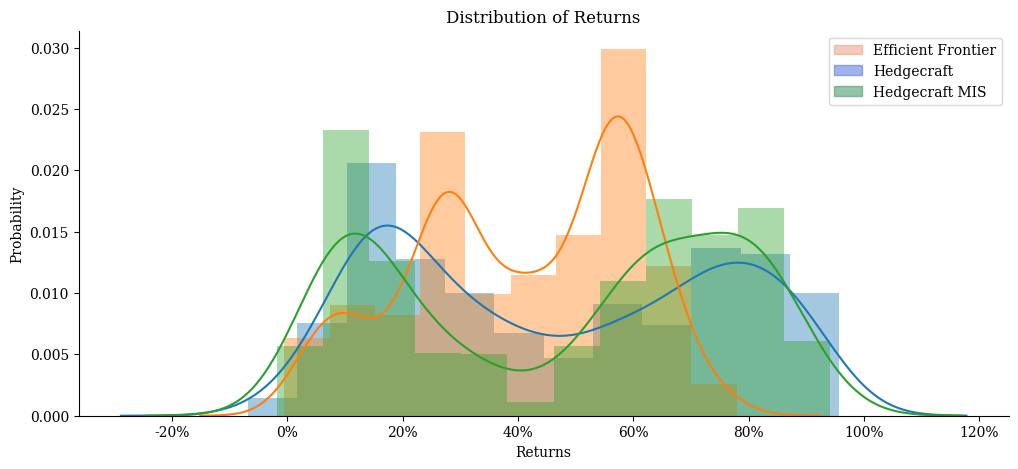

In [72]:
# function to plot many overlaping kde plots
def multi_distplot(rdist1, rdist2, rdist3, kde=True):

    # initializes figure and axis
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)

    # pretty seaborn kde plots for each model
    sns.distplot(rdist1, bins=12, kde=bool)
    sns.distplot(rdist2, bins=10, kde=bool)
    sns.distplot(rdist3, bins=12, kde=bool)

    # gets xticks
    vals1 = ax.get_xticks()

    # reformats xticks to pcts
    ax.set_xticklabels(['{:.0f}%'.format(x) for x in vals1])

    # plot labels and title
    ax.set_ylabel('Probability')
    ax.set_xlabel('Returns')
    plt.title('Distribution of Returns')

    # removes spines
    sns.despine(top=True, right=True)

    # sets legend patches color and labels
    ef_patch = mpatches.Patch(color='darksalmon', label='Efficient Frontier', alpha=0.5)
    patch = mpatches.Patch(color='royalblue', label='Hedgecraft', alpha=0.5)
    mis_patch = mpatches.Patch(color='seagreen', label='Hedgecraft MIS', alpha=0.5)

    # turns legend on with patches
    plt.legend(handles=[ef_patch, patch, mis_patch])

multi_distplot(rdist1 = daily_roi, rdist2 = ef_daily_roi, rdist3 = mis_daily_roi)

In [73]:
dist_stats_summary

Hedgecraft Hedgecraft MIS  \
probability of losing money from initial invest...      0.67%          0.11%   
maximum loss                                           -6.79%         -1.85%   
mean loss                                               -3.0%         -1.85%   
Probability of falling bellow 30 day rolling avg       27.78%         34.89%   
Probability of falling bellow 50 day rolling avg       24.33%         31.67%   
Probability of falling bellow 90 day rolling avg       21.89%         25.78%   

                                                   Efficient Frontier  
probability of losing money from initial invest...              0.11%  
maximum loss                                                   -0.51%  
mean loss                                                      -0.51%  
Probability of falling bellow 30 day rolling avg               38.11%  
Probability of falling bellow 50 day rolling avg               32.11%  
Probability of falling bellow 90 day rolling avg               26.22%

# Conclusion :
The return distribution of the MIS portfolio is closer to a normal (symmetric) shape, whereas both the Hedgecraft portfolio and the efficient frontier exhibit noticeable right skewness. This right skew in Hedgecraft portfolios reflects their strong upward momentum and sustained growth over time. Typically, a positively skewed return distribution suggests a higher growth-to-risk ratio. Hedgecraft also demonstrates lower average rolling maximum drawdowns and a lower likelihood of dipping below rolling averages, pointing to a steadier growth pattern compared to the MIS portfolio.

In essence, Hedgecraft delivers more stable growth in terms of return velocity, while the MIS variant offers more consistent growth in terms of return acceleration. Put differently: Hedgecraft maintains a steadier pace of returns, while the MIS portfolio maintains a steadier rate of change in those returns.

# Final Thoughts :

This notebook demonstrated how network science can offer fresh perspectives on portfolio construction and asset selection.

Key takeaways:

  * Financial networks allow for intuitive visualization of market structure

  * Centrality metrics and MIS selection promote diversification and robustness

  * Non-linear dependencies (via distance correlation) improve understanding beyond classical methods

Future work:

  * Dynamic networks that evolve over time (e.g., rolling windows)

  * Community detection to cluster assets before optimization

  * Integration with machine learning models for predictive allocation